In [125]:
import sys
import os
import functools
import scipy
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm
import pickle
import math
import subprocess
import warnings

sys.path.insert(2, "/global/projecta/projectdirs/lux/data")
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/' )
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/aLib' )
import __init__ as S
import dp as dp
from scipy.optimize import OptimizeWarning

warnings.simplefilter("error", OptimizeWarning)
pylab.rcParams["figure.figsize"]=15,8
np.seterr(invalid='ignore')

filedir = "/project/projectdirs/lux/users/weiji/"


In [2]:
# Tritium September 2015
ts4 = np.load("/global/homes/s/salsum/projsalsum/pickles/ts5_3.pickle")


In [3]:
ts4

Dictionary contents:
                             FIELDS: TYPE                            CONTENTS
                             ------  ----                            --------
                           RQ_paths: [1 list],                        
                            fileNum: [(59893,) uint16array],         [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
                        file_number: [(59843,) uint32array],         [2932 2932 2932 2932 2932 2932...
                        numCutsPass: [1 list],                        
                     numEventsTotal: [1 int],                        216580
                            pathNum: [(59893,) uint8array],          [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
                     pulse_area_phe: [(10, 59843) float32array],     [ 15.77387238  75.49076843  42...
               pulse_classification: [(10, 59843) uint32array],      [1 1 1 1 3 1 3 1 1 1 1 1 1 1 1...
                       s1s2_pairing: [(10, 59843) uint32array],      [1 1 1 1 0 1 0 1 1 1 

In [4]:
ss4 = pickle.load(open("/project/projectdirs/lux/users/weiji/pickles/ss5_2.pickle","rb"))

In [5]:
ss4

Dictionary contents:
                             FIELDS: TYPE                            CONTENTS
                             ------  ----                            --------
                           RQ_paths: [1 list],                        
                            fileNum: [(28220,) uint16array],         [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
                        file_number: [(28220,) uint32array],         [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
                        numCutsPass: [1 list],                        
                     numEventsTotal: [1 int],                        40000
                            pathNum: [(28220,) uint8array],          [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
                     pulse_area_phe: [(10, 28220) float32array],     [  9.95289421   0.167624    25...
               pulse_classification: [(10, 28220) uint32array],      [1 5 1 1 1 1 1 1 1 1 1 1 1 1 1...
                       s1s2_pairing: [(10, 28220) uint32array],      [1 0 1 1 1 1 1 1 1 1 1

In [115]:
Efieldmap = np.loadtxt("/global/homes/w/weiji/20150208/v0_fields_20150928T2324_cp17544.txt")

In [35]:
#define a funtion do band's mean value and sigma calculation
def f(x, a, b, c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

def bandfit(x, y, bins=10, range=None, normed=False, weights=None):
    H, xedges,yedges = np.histogram2d(x, y, bins, range, normed, weights)
    log10xlist=[]
    mu=[]
    sigma=[]
    for ii in xrange(0,xedges.shape[0]-1):
        try:
            log10y = [0.5 * (yedges[i] + yedges[i+1]) for i in xrange(yedges.shape[0]-1)]
            Hx = H[ii,:]
            popt, pcov = sp.optimize.curve_fit(f, log10y, Hx)
            log10xlist.append(0.5 * (xedges[ii] + xedges[ii+1]))
            mu.append(popt[1])
            sigma.append(popt[2])
        except BaseException:
            print "Fitting data in bin ",ii,"failed."
    return(np.array(mu),np.abs(sigma),np.array(log10xlist))


In [8]:
def LoadXYZDependentEField(EFieldMap, NumxyzDependentEFieldVars = 8, MinLocationX = -23.50 ,NumPlanesX = 48, StepSizeX = 1. ,MinLocationY = -23.50 ,NumPlanesY = 48, StepSizeY = 1.,MinLocationZ = -33.975 ,NumPlanesZ = 50, StepSizeZ = 1.):
    EFieldMapMatrix = np.zeros((NumPlanesX,NumPlanesY,NumPlanesZ,NumxyzDependentEFieldVars))
    for ii in xrange(0,EFieldMap.shape[0]):
        xx = (int)((EFieldMap[ii,0]-MinLocationX)/StepSizeX)
        yy = (int)((EFieldMap[ii,1]-MinLocationY)/StepSizeY)
        zz = (int)((EFieldMap[ii,2]-MinLocationZ)/StepSizeZ)
        for vv in xrange(0,NumxyzDependentEFieldVars):
            if vv == 2:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv] - MinLocationZ +5.6
            elif vv==6:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv]
            else:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv]
            
                
    return EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))

def GetXYZDependentElectricField(x,LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap
    xx = (int)((x[0]-MinLocationX)/StepSizeX)
    yy = (int)((x[1]-MinLocationY)/StepSizeY)
    if (xx<0 or xx>NumPlanesX-2 or yy<0 or yy>NumPlanesY-2):
#   if 0:
        return -100000
    else:
        distance2 = (x[0]-EFieldMapMatrix[xx,yy,0,0])**2+(x[1]-EFieldMapMatrix[xx,yy,0,1])**2
        for xxx in xrange(xx,xx+1):
            for yyy in xrange(yy,yy+1):                
                    if distance2 > ((x[0]-EFieldMapMatrix[xxx,yyy,0,0])**2+(x[1]-EFieldMapMatrix[xxx,yyy,0,1])**2):                                               
                        xx = xxx
                        yy = yyy
        zz=0
#        print xx,yy
        dist = np.abs(x[2]-EFieldMapMatrix[xx,yy,0,6])
#        print dist
        for zzz in xrange(0,NumPlanesZ):
            if np.abs(x[2]-EFieldMapMatrix[xx,yy,zzz,6])<dist:
                dist = np.abs(x[2]-EFieldMapMatrix[xx,yy,zzz,6])
                zz=zzz
    if ifprint:
        print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
        print "x,y,z,",EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2]
        print "S2x,S2y,t,",EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6]
    return EFieldMapMatrix[xx,yy,zz,3]

def GetXYZDependentElectricField_s2(x,LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    try:
        xx=0
        yy=0
        zz=0
        distance2 = 10000
        for xxx in xrange(0,NumPlanesX):
            for yyy in xrange(0,NumPlanesY):  
                 for zzz in xrange(0,NumPlanesZ):
                    if distance2 > ((x[0]-EFieldMapMatrix[xxx,yyy,zzz,4])**2+(x[1]-EFieldMapMatrix[xxx,yyy,zzz,5])**2)+(x[2]-EFieldMapMatrix[xxx,yyy,zzz,6])**2/144.:                                               
                        xx = xxx
                        yy = yyy
                        zz = zzz
                        distance2 = (x[0]-EFieldMapMatrix[xxx,yyy,zzz,4])**2+(x[1]-EFieldMapMatrix[xxx,yyy,zzz,5])**2+(x[2]-EFieldMapMatrix[xxx,yyy,zzz,6])**2/144.
        if ifprint:
            print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
            print "x,y,z,",EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2]
            print "S2x,S2y,t,",EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6]

            print distance2
        return EFieldMapMatrix[xx,yy,zz,:]
    except :
        return -100000

In [9]:
def errorf(x,*args):
    (S2x,S2y,T),(x0,y0,z0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz) = args
    return (S2x - (s2x0 + (x[0]-x0)*ds2xdx + (x[1]-y0)*ds2xdy + (x[2]-z0)*ds2xdz))**2 \
            +(S2y - (s2y0 + (x[0]-x0)*ds2ydx + (x[1]-y0)*ds2ydy + (x[2]-z0)*ds2ydz))**2 \
            +(T - (t0 + (x[0]-x0)*dtdx + (x[1]-y0)*dtdy + (x[2]-z0)*dtdz))**2 

def intepolation(x,x0,f0,dfdx):
    x=np.array(x)
    x0 = np.array(x0)
    dfdx = np.array(dfdx)
    return f0+np.sum(dfdx*(x-x0))

def GetXYZFromXYZS2TDependentElectricField((S2x,S2y,DriftTime),LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    """
        This function is getting real x y z E from known S2x,S2y,DriftTime,fieldmap
        S2x, S2y in cm
        DriftTime in us
    """
    warnings.filterwarnings('error')
    try:
        xx=25
        yy=25
        zz=25
        attempt=50
        notsuccess = 1
        while((attempt > 0) and notsuccess):
            attempt-=1
            notsuccess = 0
            
            if S2x< EFieldMapMatrix[xx,yy,zz,4]:
                notsuccess = 1
                xx -= 1
            elif S2x > EFieldMapMatrix[xx+1,yy,zz,4]:
                notsuccess = 1
                xx += 1
            if S2y< EFieldMapMatrix[xx,yy,zz,5]:
                notsuccess = 1
                yy -= 1
            elif S2y > EFieldMapMatrix[xx,yy+1,zz,5]:
                notsuccess = 1
                yy += 1
            if DriftTime < EFieldMapMatrix[xx,yy,zz,6]:
                notsuccess = 1
                zz += 1
            elif DriftTime > EFieldMapMatrix[xx,yy,zz+1,6]:
                notsuccess = 1
                zz -= 1
            if xx<0 or xx >NumPlanesX-2 or yy<0 or yy >NumPlanesY-2 or zz<0 or zz >NumPlanesZ-2:
                if ifprint:
                    print "(S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns ) is OUT of range in the field map."
                return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
            if ifprint:
                print "attempt",attempt
                print "xx,yy,zz",xx,yy,zz
        if ifprint:
            print "xx,yy,zz",xx,yy,zz
        if attempt ==0 and ifprint:
            print "Did not find a point in the map matches with (S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns )"
            print "One of the closest point is (S2x =",EFieldMapMatrix[xx,yy,zz,4],"cm, S2y =",EFieldMapMatrix[xx,yy,zz,5],"cm, DriftTime =",EFieldMapMatrix[xx,yy,zz,6],"ns )"
            print "Check whether you are using the right field map and right S2x, S2y,S2z",attempt
        if xx<0 or xx >NumPlanesX-2 or yy<0 or yy >NumPlanesY-2 or zz<0 or zz >NumPlanesZ-2 or\
            np.isnan(EFieldMapMatrix[xx,yy,zz,3])            :
            if ifprint:
                print "(S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns ) is OUT of range in the field map."
            return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
        def dfdx(xx,yy,zz,num):
            dfdx = 1./4./StepSizeX*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]-EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdy = 1./4./StepSizeY*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     +EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]-EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdz = 1./4./StepSizeZ*(-EFieldMapMatrix[xx,yy,zz,num]+EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            return (dfdx,dfdy,dfdz)
        (ds2xdx,ds2xdy,ds2xdz) = dfdx(xx,yy,zz,4)
        (ds2ydx,ds2ydy,ds2ydz) = dfdx(xx,yy,zz,5)
        (dtdx,dtdy,dtdz)   = dfdx(xx,yy,zz,6)
        (xreal0,yreal0,zreal0) = (EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2])
        (s2x0,s2y0,t0) = (EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6])
           
        result= sp.optimize.fmin(errorf,x0=(xreal0,yreal0,zreal0),args = ((S2x,S2y,DriftTime),(xreal0,yreal0,zreal0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz)),disp=0)
        if ifprint:
            print result
        (xreal,yreal,zreal) = result
        E = intepolation((xreal,yreal,zreal),(xreal0,yreal0,zreal0),EFieldMapMatrix[xx,yy,zz,3],dfdx(xx,yy,zz,3))
        
        if ifprint:
            print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
            print xreal,yreal,zreal,E,S2x,S2y,DriftTime,EFieldMapMatrix[xx,yy,zz,7]

        
    except BaseException:
        return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
    #return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
    return (xreal,yreal,zreal,E,S2x,S2y,DriftTime,EFieldMapMatrix[xx,yy,zz,7])

In [116]:
LoadEFieldMap = LoadXYZDependentEField(Efieldmap)

In [11]:
#GetXYZDependentElectricField((raw_x_ts4[2],raw_x_ts4[2],drift_time_ts4[2]),LoadEFieldMap,ifprint=1)
#print raw_x_ts4[2],raw_x_ts4[2],drift_time_ts4[2]

In [12]:
mask_S1_ts4 = (ts4.pulse_classification==1)&(ts4.s1s2_pairing==1)
mask_S2_ts4 = (ts4.pulse_classification==2)&(ts4.s1s2_pairing==1)

In [13]:
S1_ts4 = (ts4.xyz_corrected_pulse_area_all_phe*mask_S1_ts4).sum(0)
S2_ts4 = (ts4.xyz_corrected_pulse_area_all_phe*mask_S2_ts4).sum(0)

In [14]:
raw_x_ts4 = (ts4.x_cm*mask_S2_ts4).sum(0) #this is ok since i have verified there is only
raw_y_ts4 = (ts4.y_cm*mask_S2_ts4).sum(0) #one S2 in each event that has made it through cuts
raw_x_del_ts4 = (ts4.x_cm_del*mask_S2_ts4).sum(0) #this is ok since i have verified there is only
raw_y_del_ts4 = (ts4.y_cm_del*mask_S2_ts4).sum(0) #one S2 in each event that has made it through cuts
drift_time_ts4 = (ts4.z_drift_samples*mask_S2_ts4).sum(0)/100.
negative_drift_time_ts4 = [0-a for a in drift_time_ts4]
raw_r_ts4 = (raw_x_ts4**2 + raw_y_ts4**2)**(1./2)# mask out only tritium_energies this is a mask on an entire event not a pulse
# possibly add a radial cut
# possibly add a drift time cut
mask_tritium_energy_ts4 = (np.log10(S1_ts4)<2.5)&(np.log10(S2_ts4)<5.0)&(3.1<np.log10(S2_ts4))
tS1_ts4 = []
tS2_ts4 = []
traw_x_ts4 = []
traw_y_ts4 = []
traw_r_ts4 = []
tdrift_time_ts4 = []
x_del_ts4=[]
y_del_ts4=[]
for aa in range(len(mask_tritium_energy_ts4)):
    if mask_tritium_energy_ts4[aa] == True:
        tS1_ts4.append(S1_ts4[aa])
        tS2_ts4.append(S2_ts4[aa])
        traw_x_ts4.append(raw_x_ts4[aa])
        traw_y_ts4.append(raw_y_ts4[aa])
        traw_r_ts4.append(raw_r_ts4[aa])
        tdrift_time_ts4.append(drift_time_ts4[aa])
        x_del_ts4.append(raw_x_del_ts4[aa])
        y_del_ts4.append(raw_y_del_ts4[aa])
S1_t_ts4 = np.array(tS1_ts4)
S2_t_ts4 = np.array(tS2_ts4)
raw_x_t_ts4 = np.array(traw_x_ts4)
raw_y_t_ts4 = np.array(traw_y_ts4)
raw_r_t_ts4 = np.array(traw_r_ts4)
drift_time_t_ts4 = np.array(tdrift_time_ts4)
negative_drift_time_t_ts4 = [0-a for a in drift_time_t_ts4]
x_del_ts4 = np.array(x_del_ts4)
y_del_ts4 = np.array(y_del_ts4)

In [15]:
# G1 is .104 according to Richard's presentation for Sept 2014
# G2 is 19.15
g1_s4 = 0.104
g2_s4 = 19.15
W = 13.7/1000

S1_energy_t_ts4 = W*S1_t_ts4/g1_s4
S2_energy_t_ts4 = W*S2_t_ts4/g2_s4
Combined_energy_t_ts4 = S1_energy_t_ts4 + S2_energy_t_ts4

In [16]:
Efield_ts4=[]
for ii in xrange(len(x_del_ts4)):
    Efield_ts4.append(GetXYZDependentElectricField((x_del_ts4[ii],y_del_ts4[ii],drift_time_t_ts4[ii]),LoadEFieldMap))
Efield_ts4= np.array(Efield_ts4)

In [117]:
WantToSleep = 1

In [18]:
if(WantToSleep):
    Efield_s2_ts4=[]
    x_real_s2_ts4=[]
    y_real_s2_ts4=[]
    z_real_s2_ts4=[]
    for ii in xrange(len(raw_x_t_ts4)):
        temp =  GetXYZFromXYZS2TDependentElectricField((raw_x_t_ts4[ii],raw_y_t_ts4[ii],drift_time_t_ts4[ii]),LoadEFieldMap)
        x_real_s2_ts4.append(temp[0])
        y_real_s2_ts4.append(temp[1])
        z_real_s2_ts4.append(temp[2])
        Efield_s2_ts4.append(temp[3])
    Efield_s2_ts4= np.array(Efield_s2_ts4)
    x_real_s2_ts4= np.array(x_real_s2_ts4)
    y_real_s2_ts4= np.array(y_real_s2_ts4)
    z_real_s2_ts4= np.array(z_real_s2_ts4)

In [19]:
Efield_ts4

array([  2460.8  ,   7093.099,  38578.111, ...,  14984.373,  52648.31 ,
         9743.252])

In [20]:
Efield_s2_ts4

array([  3352.59522131,   6810.45111296,  39274.95930406, ...,
        13989.85036251,  51366.76181278,  10447.78594284])

In [21]:
mask_S1_ss4 = (ss4.pulse_classification==1)&(ss4.s1s2_pairing==1)
mask_S2_ss4 = (ss4.pulse_classification==2)&(ss4.s1s2_pairing==1)

In [22]:
S1_ss4 = (ss4.xyz_corrected_pulse_area_all_phe*mask_S1_ss4).sum(0)
S2_ss4 = (ss4.xyz_corrected_pulse_area_all_phe*mask_S2_ss4).sum(0)

In [23]:
raw_x_ss4 = (ss4.x_cm*mask_S2_ss4).sum(0) #this is ok since i have verified there is only
raw_y_ss4 = (ss4.y_cm*mask_S2_ss4).sum(0) #one S2 in each event that has made it through cuts
drift_time_ss4 = (ss4.z_drift_samples*mask_S2_ss4).sum(0)/100
negative_drift_time_ss4 = [0-a for a in drift_time_ss4]
raw_r_ss4 = (raw_x_ss4**2 + raw_y_ss4**2)**(1./2)
x_del_ss4 = (ss4.x_cm_del*mask_S2_ss4).sum(0)
y_del_ss4 = (ss4.y_cm_del*mask_S2_ss4).sum(0)

In [24]:
S1_energy_ss4 = W*S1_ss4/g1_s4
S2_energy_ss4 = W*S2_ss4/g2_s4
Combined_energy_ss4 = S1_energy_ss4 + S2_energy_ss4

In [25]:
Efield_ss4=[]
for ii in xrange(len(x_del_ss4)):
    Efield_ss4.append(GetXYZDependentElectricField((x_del_ss4[ii],y_del_ss4[ii],drift_time_ss4[ii]),LoadEFieldMap))
Efield_ss4= np.array(Efield_ss4)

In [118]:
if(WantToSleep):
    Efield_s2_ss4=[]
    x_real_s2_ss4=[]
    y_real_s2_ss4=[]
    z_real_s2_ss4=[]
    for ii in xrange(10000):
        temp = GetXYZFromXYZS2TDependentElectricField((raw_x_ss4[ii],raw_y_ss4[ii],drift_time_ss4[ii]),LoadEFieldMap)
        x_real_s2_ss4.append(temp[0])
        y_real_s2_ss4.append(temp[1])
        z_real_s2_ss4.append(temp[2])
        Efield_s2_ss4.append(temp[3])
    Efield_s2_ss4= np.array(Efield_s2_ss4)
    x_real_s2_ss4= np.array(x_real_s2_ss4)
    y_real_s2_ss4= np.array(y_real_s2_ss4)
    z_real_s2_ss4= np.array(z_real_s2_ss4)

In [119]:
WantToSleep = 0

Fitting data in bin  39 failed.
Fitting data in bin  41 failed.
Fitting data in bin  47 failed.


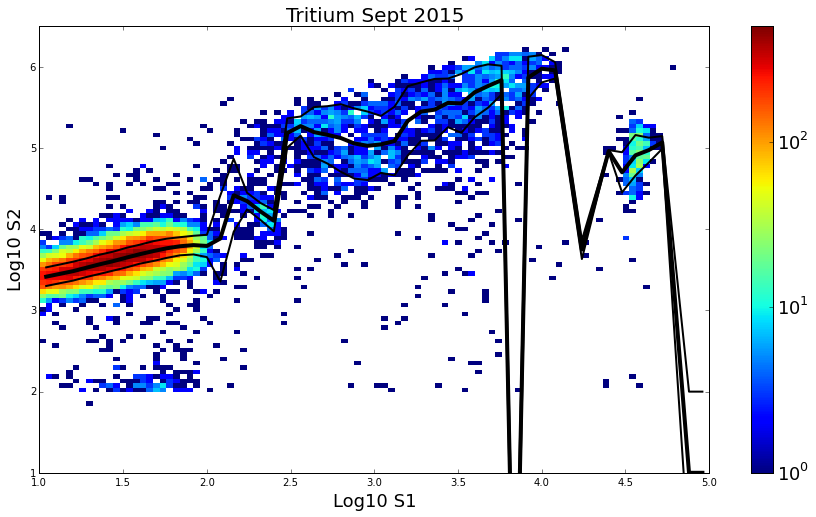

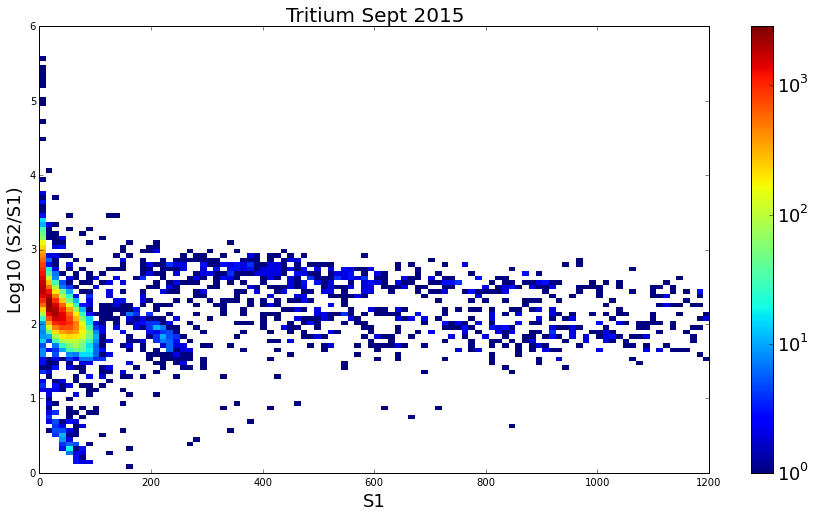

In [165]:
# S2 vs S1
plt.figure(10)
plt.hist2d(np.log10(S1_ts4),np.log10(S2_ts4),range=[[1,5],[1,6.5]],bins=(100,100),norm=LogNorm())
(mu,sigma,log10xlist)=bandfit(np.log10(S1_ts4),np.log10(S2_ts4),range=[[1,5],[1,6.5]],bins=(50,100),)
plt.plot(log10xlist,mu,lw=4, color="k")
plt.plot(log10xlist,np.array(mu)+np.array(np.abs(sigma)),"k-",lw=2)
plt.plot(log10xlist,np.array(mu)-np.array(np.abs(sigma)),"k-",lw=2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xlabel("Log10 S1", fontsize=18)
plt.ylabel("Log10 S2", fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

# Traditional band plot
plt.figure(20)
plt.hist2d(S1_ts4, np.log10(S2_ts4)-np.log10(S1_ts4),range=[[0,1200],[0,6]],bins=(100,100),norm=LogNorm())
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xlabel("S1", fontsize=18)
plt.ylabel("Log10 (S2/S1)", fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

Fitting data in bin  89 failed.
Fitting data in bin  90 failed.
Fitting data in bin  91 failed.
Fitting data in bin  93 failed.
Fitting data in bin  90 failed.
Fitting data in bin  93 failed.
Fitting data in bin  95 failed.
Fitting data in bin  96 failed.
Fitting data in bin  97 failed.
Fitting data in bin  98 failed.


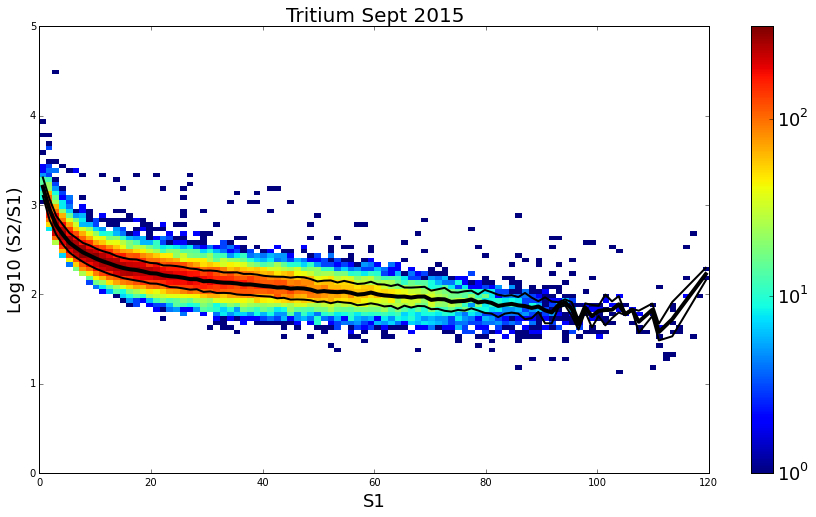

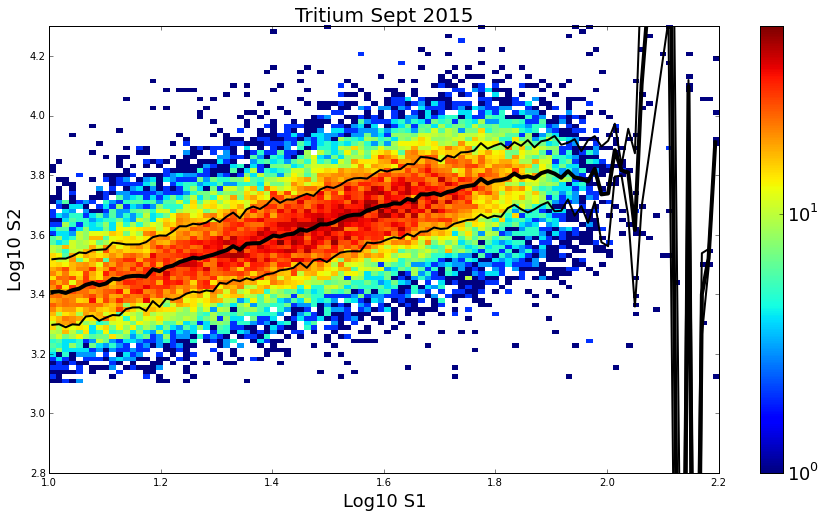

In [36]:
# S2 vs S1
plt.figure(30)
plt.hist2d(np.log10(S1_t_ts4),np.log10(S2_t_ts4),range=[[1,2.2],[2.8,4.3]],bins=(100,100),norm=LogNorm())
bandfit1=bandfit(np.log10(S1_t_ts4),np.log10(S2_t_ts4),range=[[1,2.2],[2.8,4.3]],bins=(100,100),)
plt.plot(bandfit1[2],bandfit1[0],lw=4, color="k")
plt.plot(bandfit1[2],np.array(bandfit1[0])+np.array(np.abs(bandfit1[1])),"k-",lw=2)
plt.plot(bandfit1[2],np.array(bandfit1[0])-np.array(np.abs(bandfit1[1])),"k-",lw=2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xlabel("Log10 S1", fontsize=18)
plt.ylabel("Log10 S2", fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

# Traditional band plot
plt.figure(40)
plt.hist2d(S1_t_ts4, np.log10(S2_t_ts4)-np.log10(S1_t_ts4),range=[[0,120],[0,5]],bins=(100,100),norm=LogNorm())
bandfit2=bandfit(S1_t_ts4, np.log10(S2_t_ts4)-np.log10(S1_t_ts4),range=[[0,120],[0,5]],bins=(100,100),)
plt.plot(bandfit2[2],bandfit2[0],lw=4, color="k")
plt.plot(bandfit2[2],np.array(bandfit2[0])+np.array(np.abs(bandfit2[1])),"k-",lw=2)
plt.plot(bandfit2[2],np.array(bandfit2[0])-np.array(np.abs(bandfit2[1])),"k-",lw=2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xlabel("S1", fontsize=18)
plt.ylabel("Log10 (S2/S1)", fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

Fitting data in bin  86 failed.
Fitting data in bin  87 failed.
Fitting data in bin  89 failed.
Fitting data in bin  88 failed.
Fitting data in bin  89 failed.
Fitting data in bin  91 failed.
Fitting data in bin  93 failed.
Fitting data in bin  98 failed.


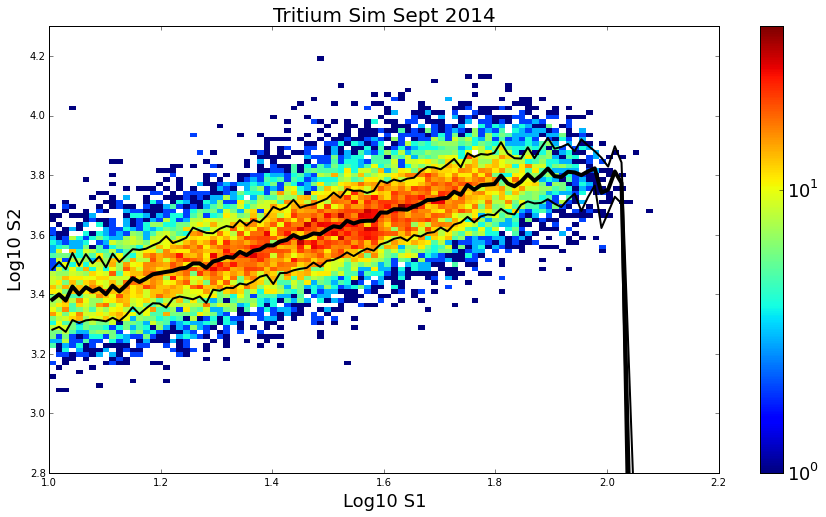

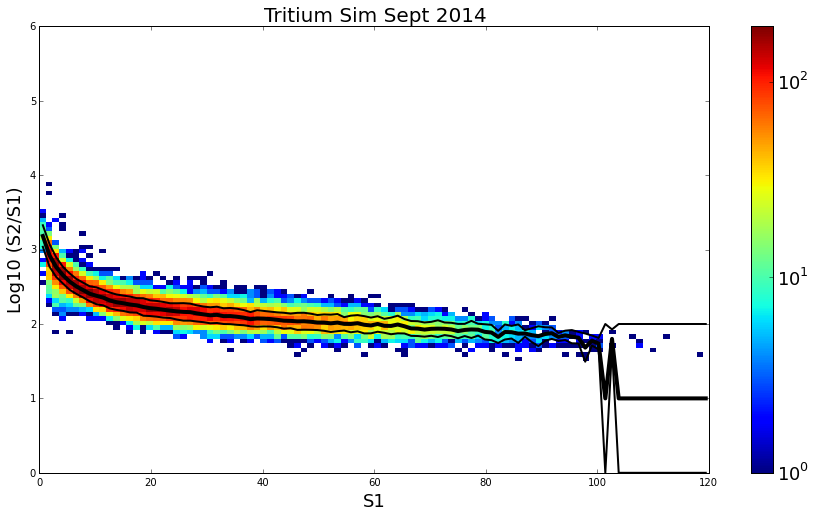

In [37]:
# S2 vs S1
plt.figure(11)
plt.hist2d(np.log10(S1_ss4),np.log10(S2_ss4),range=[[1,2.2],[2.8,4.3]],bins=(100,100),norm=LogNorm())
bandfit01=bandfit(np.log10(S1_ss4),np.log10(S2_ss4),range=[[1,2.2],[2.8,4.3]],bins=(100,100))
plt.plot(bandfit01[2],bandfit01[0],lw=4, color="k")
plt.plot(bandfit01[2],np.array(bandfit01[0])+np.array(np.abs(bandfit01[1])),"k-",lw=2)
plt.plot(bandfit01[2],np.array(bandfit01[0])-np.array(np.abs(bandfit01[1])),"k-",lw=2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xlabel("Log10 S1", fontsize=18)
plt.ylabel("Log10 S2", fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

# Traditional band plot
plt.figure(12)
plt.hist2d(S1_ss4, np.log10(S2_ss4)-np.log10(S1_ss4),range=[[0,120],[0,6]],bins=(100,100),norm=LogNorm())
bandfit02=bandfit(S1_ss4, np.log10(S2_ss4)-np.log10(S1_ss4),range=[[0,120],[0,6]],bins=(100,100))
plt.plot(bandfit02[2],bandfit02[0],lw=4, color="k")
plt.plot(bandfit02[2],np.array(bandfit02[0])+np.array(np.abs(bandfit02[1])),"k-",lw=2)
plt.plot(bandfit02[2],np.array(bandfit02[0])-np.array(np.abs(bandfit02[1])),"k-",lw=2)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.xlabel("S1", fontsize=18)
plt.ylabel("Log10 (S2/S1)", fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)


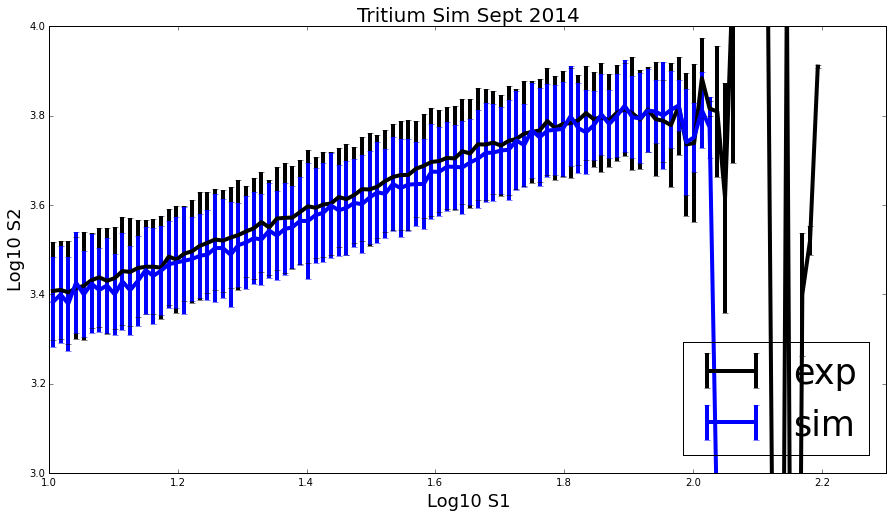

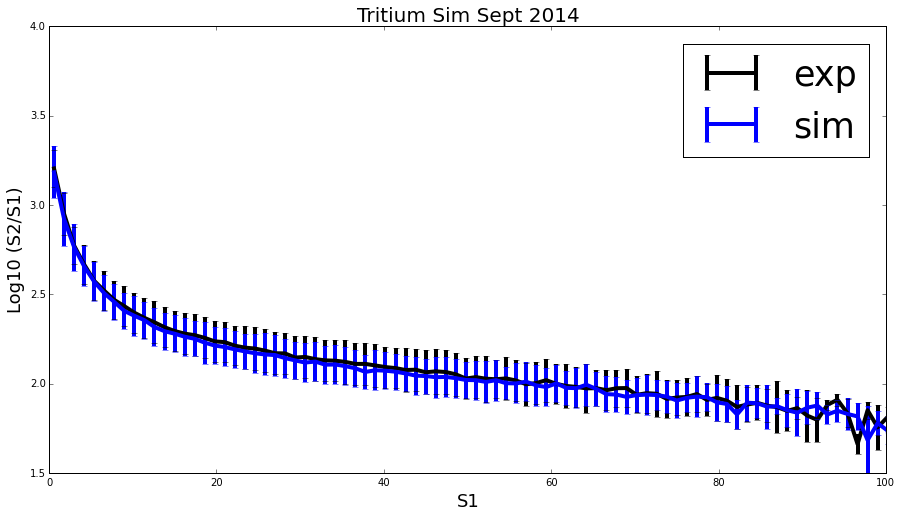

In [126]:
#comparision plot 
plt.figure(12)
plt.errorbar(bandfit1[2],bandfit1[0],bandfit1[1],lw=4, color="k",label="exp")
plt.errorbar(bandfit01[2],bandfit01[0],bandfit01[1],lw=4, color="b",label="sim")
plt.legend(loc=4,fontsize=35)
plt.xlim(1.0,2.3)
plt.ylim(3.0,4.)
plt.xlabel("Log10 S1", fontsize=18)
plt.ylabel("Log10 S2", fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)
#comparision plot 
plt.figure(22)
plt.errorbar(bandfit2[2],bandfit2[0],bandfit2[1],lw=4, color="k",label="exp")
plt.errorbar(bandfit02[2],bandfit02[0],bandfit02[1],lw=4, color="b",label="sim")
plt.legend(loc=0,fontsize=35)
plt.xlim(0,100.)
plt.ylim(1.5,4.)
plt.xlabel("S1", fontsize=18)
plt.ylabel("Log10 (S2/S1)", fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

np.save(filedir+"201509explogband",bandfit1)
np.save(filedir+"201509simlogband",bandfit01)
np.save(filedir+"201509expband",bandfit2)
np.save(filedir+"201509simband",bandfit02)


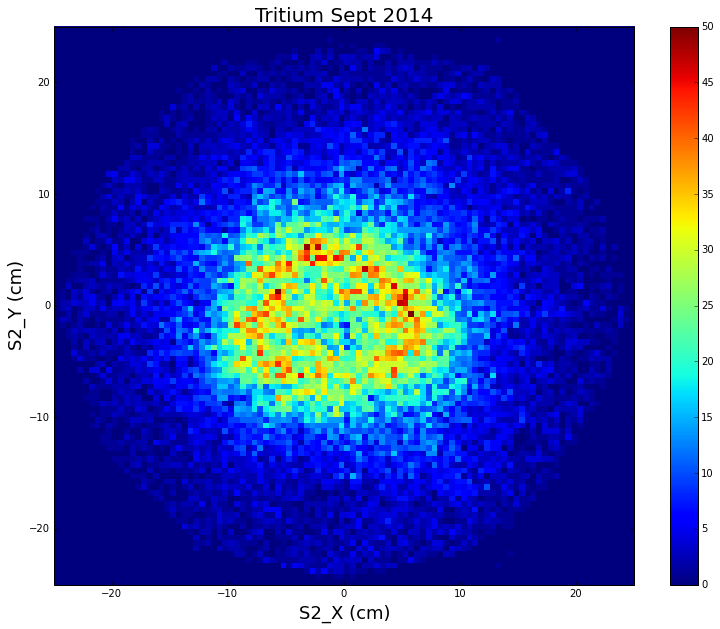

In [39]:
# Uncorrected mercury reconstruction
plt.figure(50,figsize=(13,10))
plt.hist2d(raw_x_t_ts4,raw_y_t_ts4,range=[[-25,25],[-25,25]],bins=(100,100))
cbar = plt.colorbar()
plt.xlabel("S2_X (cm)", fontsize=18)
plt.ylabel("S2_Y (cm)", fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

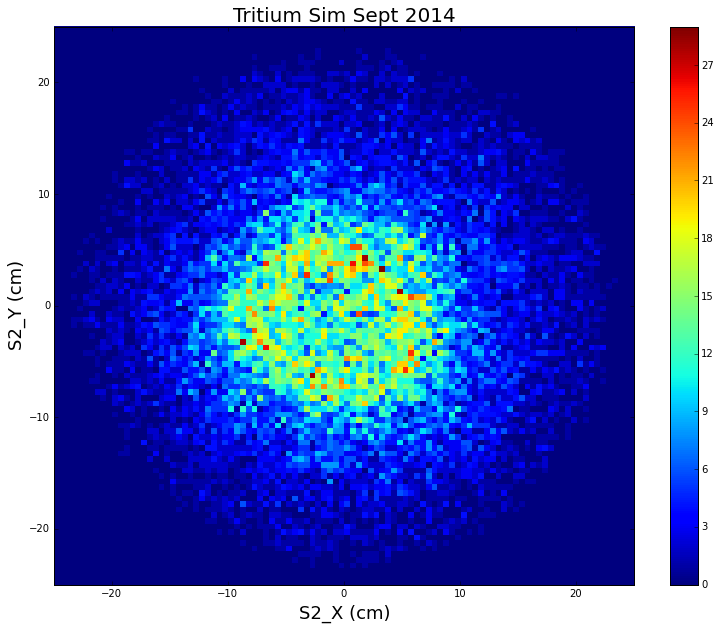

In [40]:
# Uncorrected mercury reconstruction
plt.figure(51,figsize=(13,10))
plt.hist2d(raw_x_ss4,raw_y_ss4,range=[[-25,25],[-25,25]],bins=(100,100))
cbar = plt.colorbar()
plt.xlabel("S2_X (cm)", fontsize=18)
plt.ylabel("S2_Y (cm)", fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

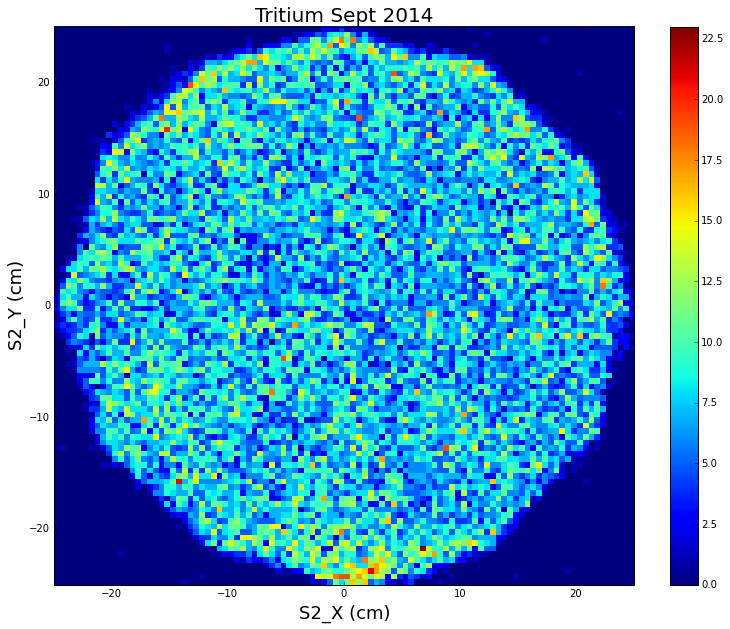

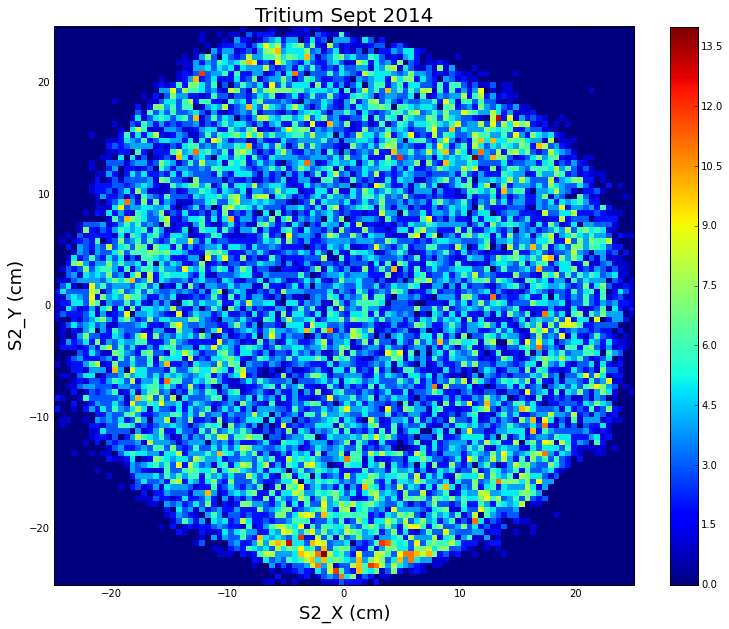

In [100]:
# corrected reconstruction
plt.figure(60,figsize=(13,10))
plt.hist2d(x_del_ts4,y_del_ts4,range=[[-25,25],[-25,25]],bins=(100,100))
cbar = plt.colorbar()
plt.xlabel("S2_X (cm)", fontsize=18)
plt.ylabel("S2_Y (cm)", fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

# corrected reconstruction
plt.figure(61,figsize=(13,10))
plt.hist2d(x_del_ss4,y_del_ss4,range=[[-25,25],[-25,25]],bins=(100,100))
cbar = plt.colorbar()
plt.xlabel("S2_X (cm)", fontsize=18)
plt.ylabel("S2_Y (cm)", fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

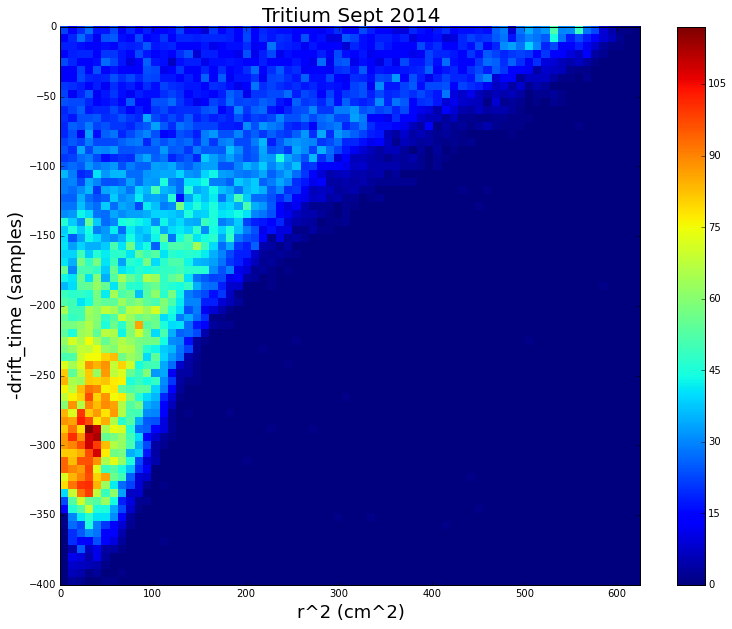

In [42]:
# dritft time vs S2R^2
plt.figure(70,figsize=(13,10))
plt.hist2d(raw_r_t_ts4**2,negative_drift_time_t_ts4,range=[[0,25**2],[-400,0]],bins=(70,70))
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("-drift_time (samples)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

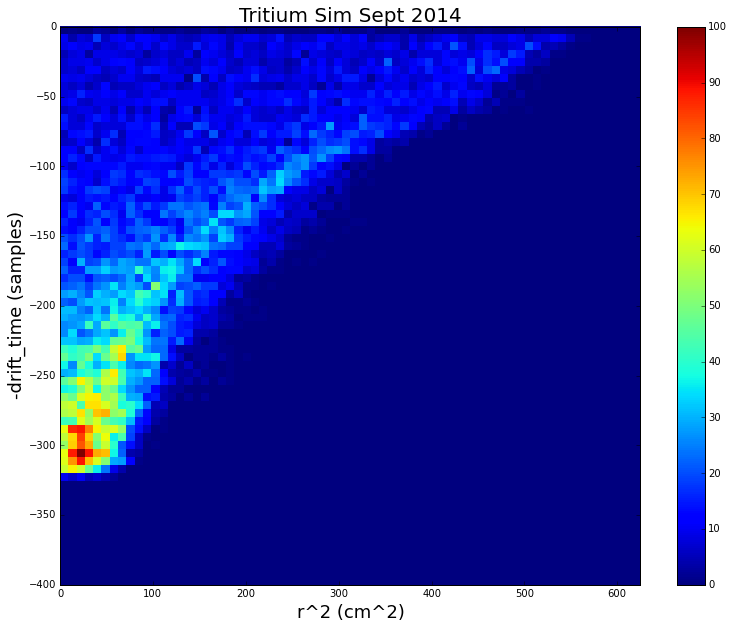

In [43]:
# dritft time vs S2R^2
plt.figure(105,figsize=(13,10))
plt.hist2d(raw_r_ss4**2,negative_drift_time_ss4,range=[[0,25**2],[-400,0]],bins=(70,70))
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("-drift_time (samples)",fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

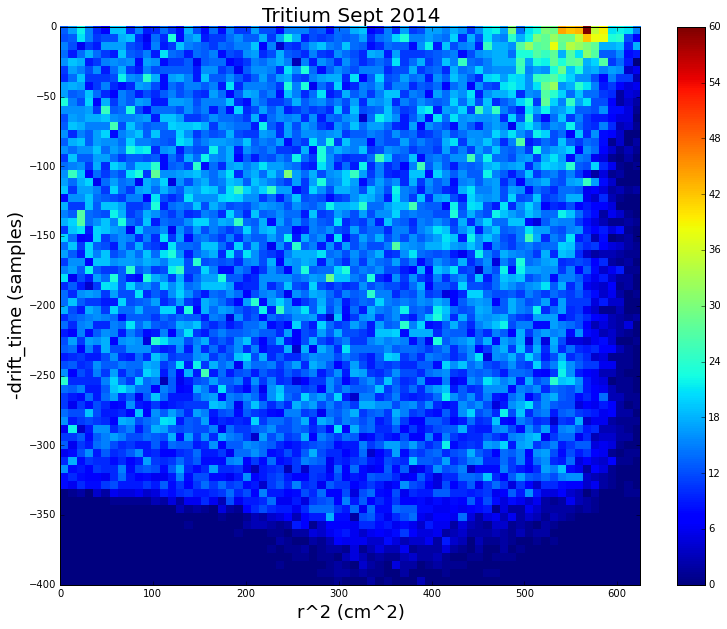

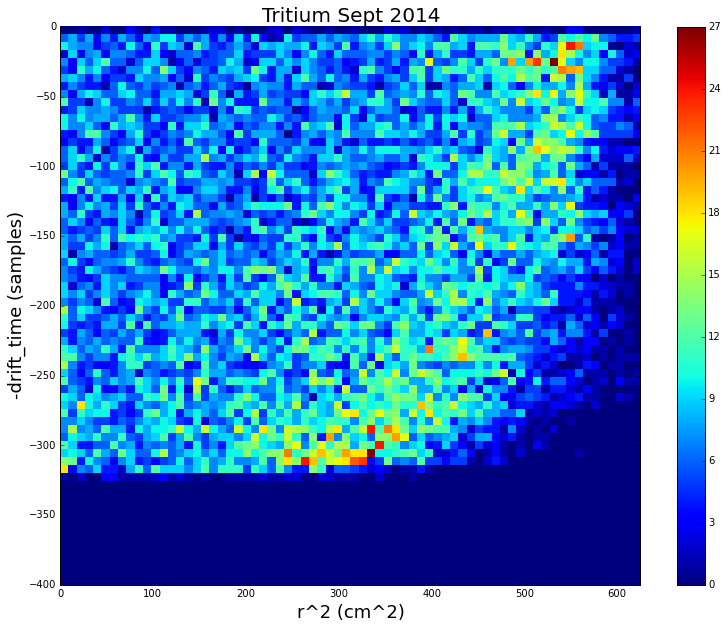

In [99]:
# dritft time vs S2R^2
plt.figure(80,figsize=(13,10))
plt.hist2d((x_del_ts4**2+y_del_ts4**2),negative_drift_time_t_ts4,range=[[0,25**2],[-400,0]],bins=(70,70))
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("-drift_time (samples)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

# dritft time vs S2R^2
plt.figure(81,figsize=(13,10))
plt.hist2d((x_del_ss4**2+y_del_ss4**2),negative_drift_time_ss4,range=[[0,25**2],[-400,0]],bins=(70,70))
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("-drift_time (samples)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

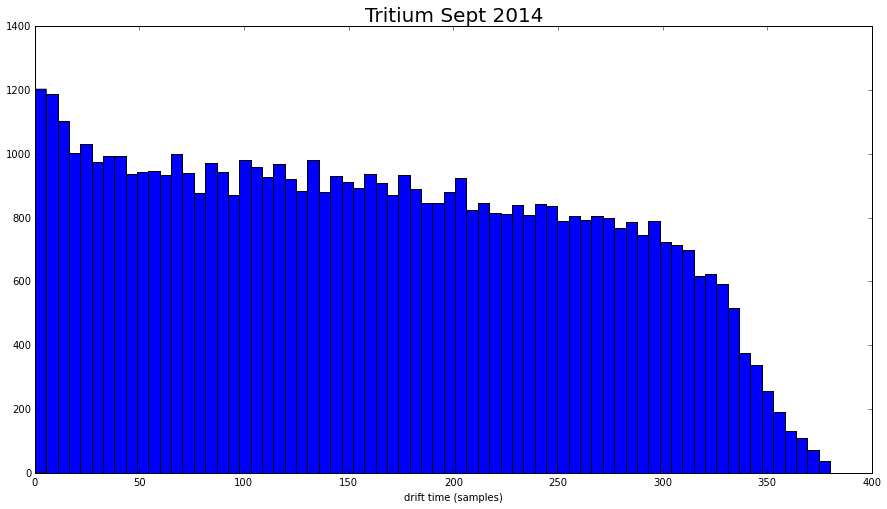

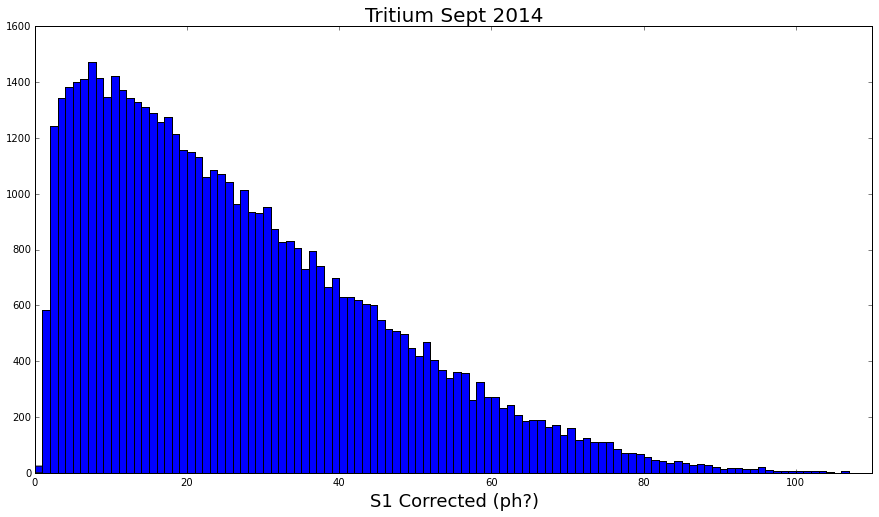

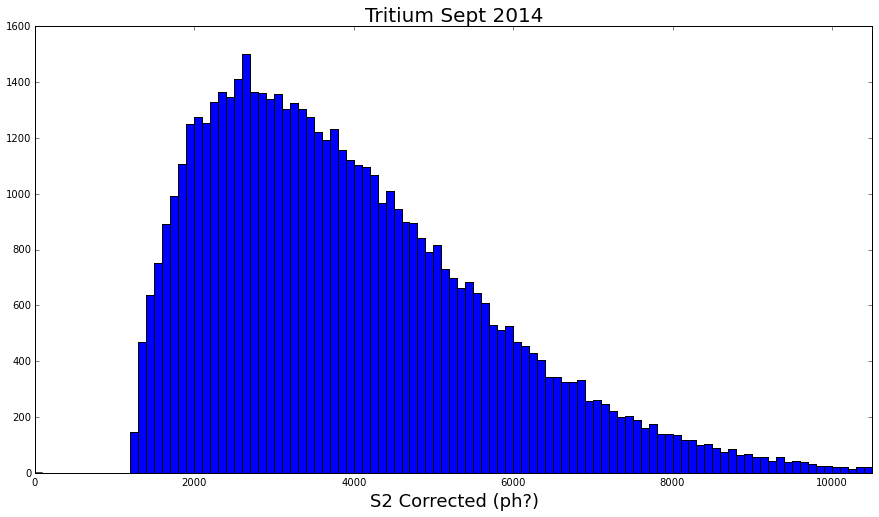

In [45]:
# drift time histogram
plt.figure(90)
plt.hist(drift_time_t_ts4, range=[0,380], bins=70)
plt.xlabel("drift time (samples)")
plt.title("Tritium Sept 2014", fontsize=20)

# Corrected S1
plt.figure(100)
plt.hist(S1_t_ts4, range=[0,110], bins=110)
plt.xlim(0,110)
plt.xlabel("S1 Corrected (ph?)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

# Corrected S2
plt.figure(101)
plt.hist(S2_t_ts4, range=[0,10500], bins=105)
plt.xlim(0,10500)
plt.xlabel("S2 Corrected (ph?)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

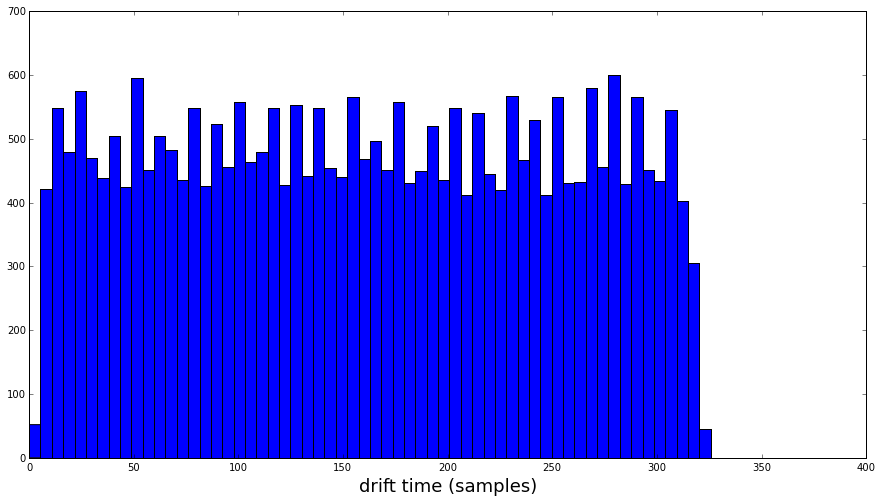

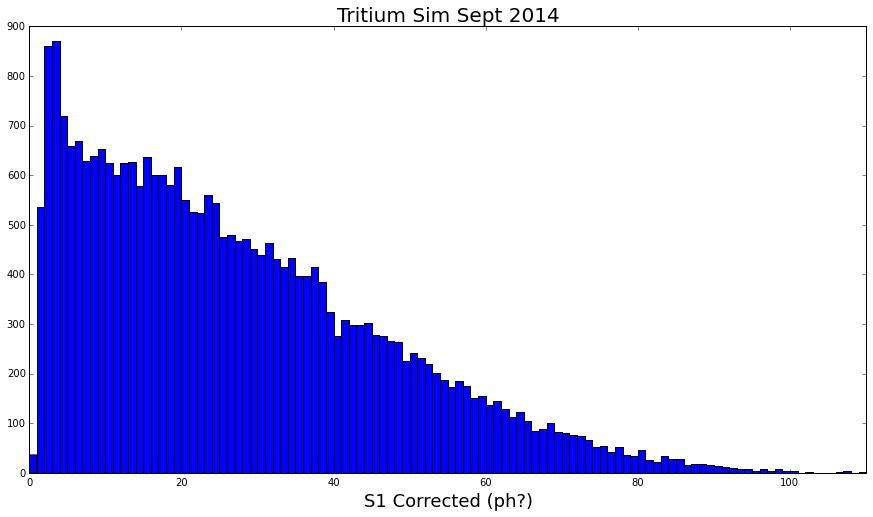

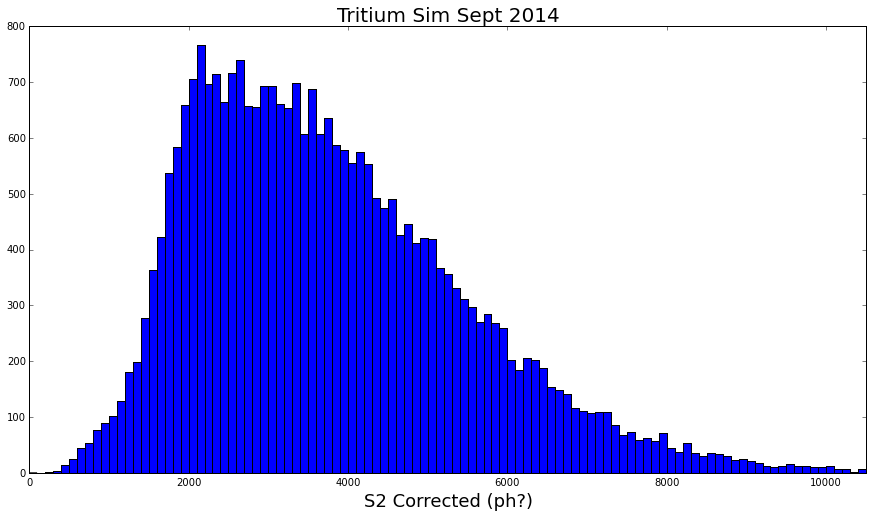

In [46]:
# drift time histogram
plt.figure(91)
plt.hist(drift_time_ss4, range=[0,380], bins=70)
plt.xlabel("drift time (samples)", fontsize=18)

# Corrected S1
plt.figure(101)
plt.hist(S1_ss4, range=[0,110], bins=110)
plt.xlim(0,110)
plt.xlabel("S1 Corrected (ph?)",fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

# Corrected S2
plt.figure(111)
plt.hist(S2_ss4, range=[0,10500], bins=105)
plt.xlim(0,10500)
plt.xlabel("S2 Corrected (ph?)",fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

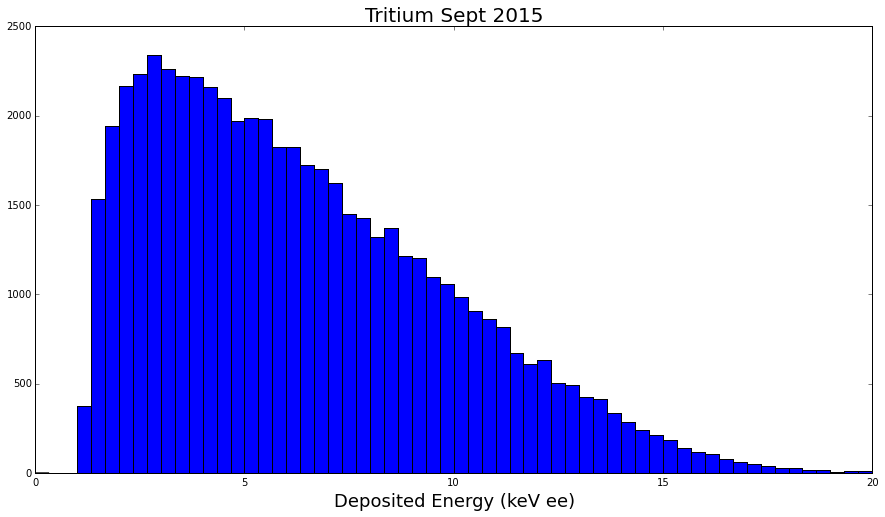

In [47]:
# combined energy
plt.figure(120)
plt.hist(Combined_energy_t_ts4, range=[0,20], bins=60)
plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

(0.028341639701844751, 1.5495715721211955e-13)


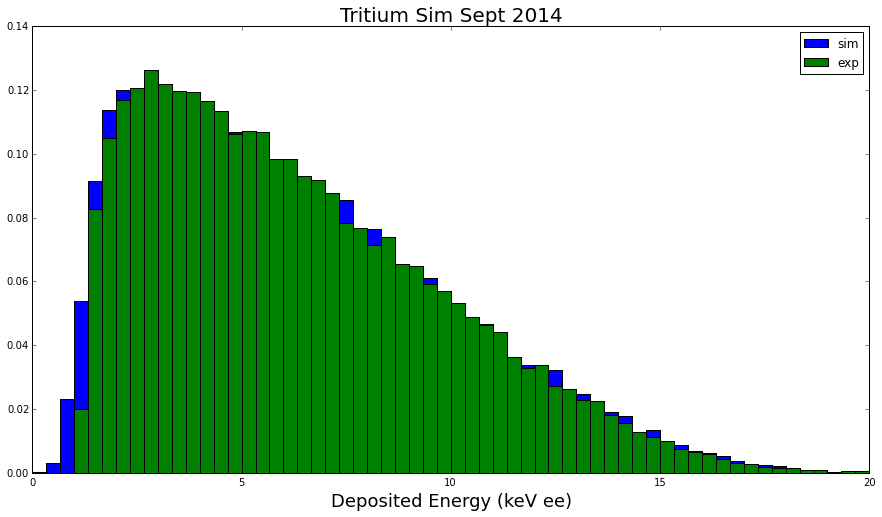

In [48]:
# combined energy
plt.figure(122)
ksTestValue =sp.stats.ks_2samp(Combined_energy_ss4,Combined_energy_t_ts4)
print ksTestValue
#plt.text(.5,.5,"KS Test Value = %g"% ksTestValue[1])
plt.hist(Combined_energy_ss4, normed =1,range=[0,20], bins=60, label = "sim")
plt.hist(Combined_energy_t_ts4, normed =1,range=[0,20], bins=60, label = "exp")
plt.legend()
plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)
plt.title("Tritium Sim Sept 2014", fontsize=20)

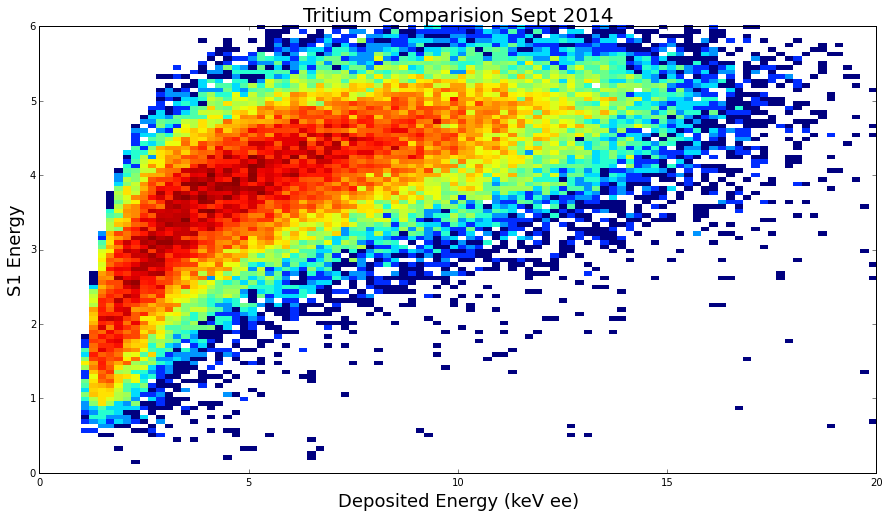

In [49]:
plt.figure(130)
plt.hist2d(Combined_energy_t_ts4, S1_t_ts4/Combined_energy_t_ts4,range=[[0,20],[0,6]],bins=(100,100),norm=LogNorm())
plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.ylabel("S1 Energy", fontsize=18)
plt.title("Tritium Comparision Sept 2014", fontsize=20)

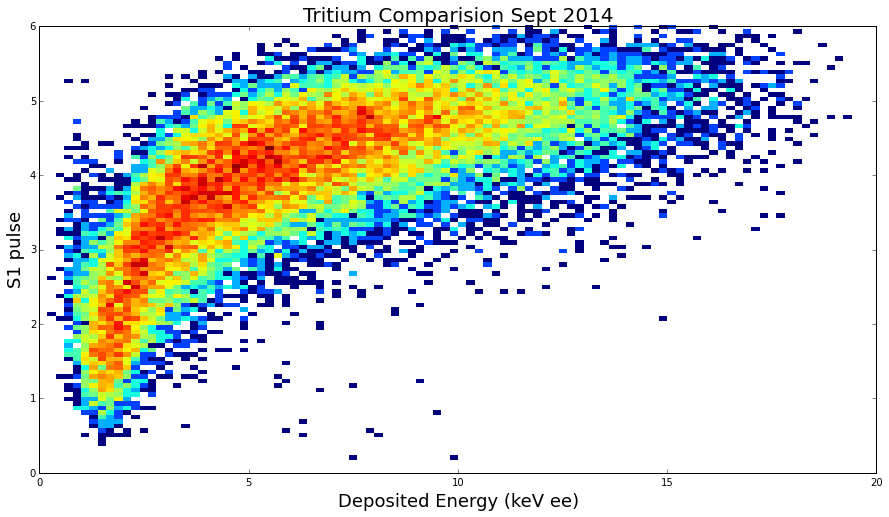

In [50]:
plt.figure(131)
plt.hist2d(Combined_energy_ss4, S1_ss4/Combined_energy_ss4,range=[[0,20],[0,6]],bins=(100,100),norm=LogNorm())
plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.ylabel("S1 pulse ", fontsize=18)
plt.title("Tritium Comparision Sept 2014", fontsize=20)

Fitting data in bin  18 failed.


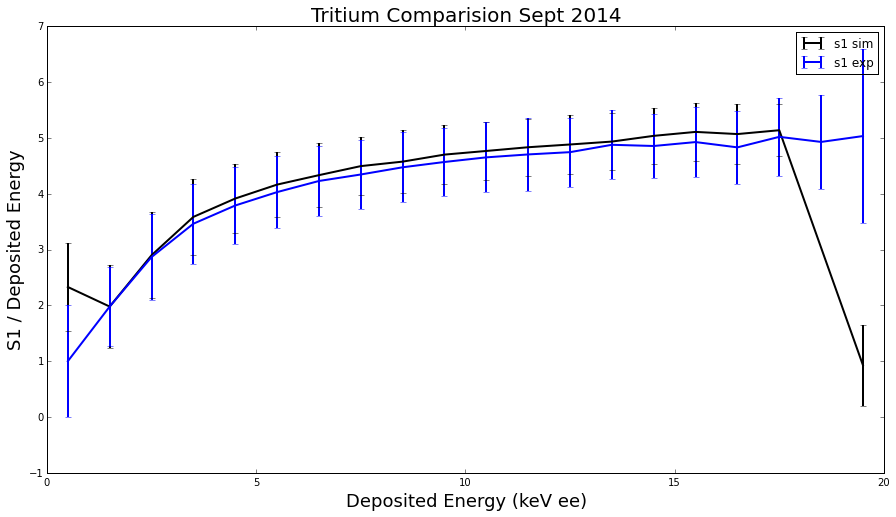

In [51]:
# light yield
plt.figure(132)
bandfit10=bandfit(Combined_energy_ss4, S1_ss4/Combined_energy_ss4,range=[[0,20],[0,7]],bins=(20,20),)
bandfit010=bandfit(Combined_energy_t_ts4, S1_t_ts4/Combined_energy_t_ts4,range=[[0,20],[0,7]],bins=(20,20),)
plt.errorbar(bandfit10[2],bandfit10[0],bandfit10[1],lw=2, color="k",label="s1 sim")
plt.errorbar(bandfit010[2],bandfit010[0],bandfit010[1],lw=2, color="b",label="s1 exp")
plt.legend(loc=0,fontsize=35)
plt.xlim(0,20.)
#plt.ylim(,)
plt.legend()
plt.xlabel("Deposited Energy (keV ee)", fontsize=18)
plt.ylabel("S1 / Deposited Energy", fontsize=18)
plt.title("Tritium Comparision Sept 2014", fontsize=20)


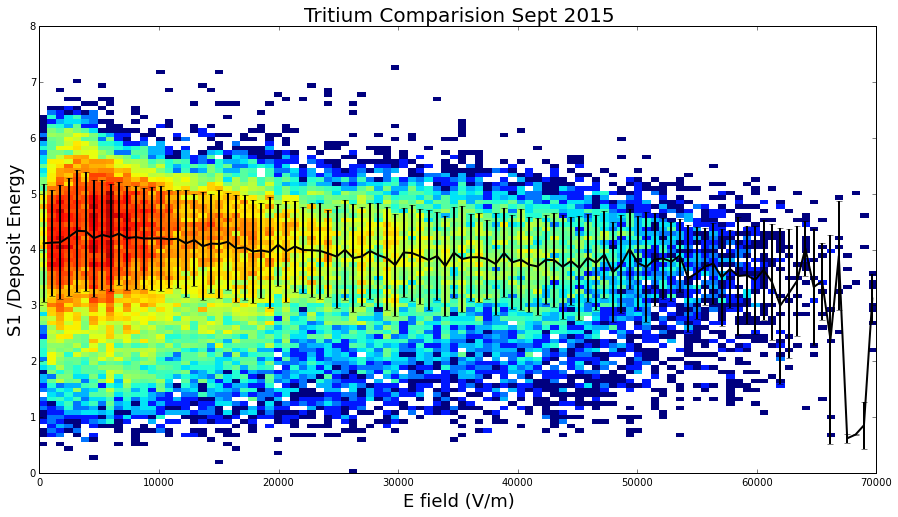

In [52]:
plt.figure(140)
plt.hist2d(Efield_ts4[~np.isnan(Efield_ts4)], S1_t_ts4[~np.isnan(Efield_ts4)]/Combined_energy_t_ts4[~np.isnan(Efield_ts4)],range=[[0,70000],[0,8]],bins=(100,100),norm=LogNorm())
bandfits140=bandfit(Efield_ts4[~np.isnan(Efield_ts4)], S1_t_ts4[~np.isnan(Efield_ts4)]/Combined_energy_t_ts4[~np.isnan(Efield_ts4)],range=[[0,70000],[0,8]],bins=(100,100))
plt.errorbar(bandfits140[2],bandfits140[0],bandfits140[1],lw=2, color="k",label="s1 sim")

plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1 /Deposit Energy", fontsize=18)
plt.title("Tritium Comparision Sept 2015", fontsize=20)

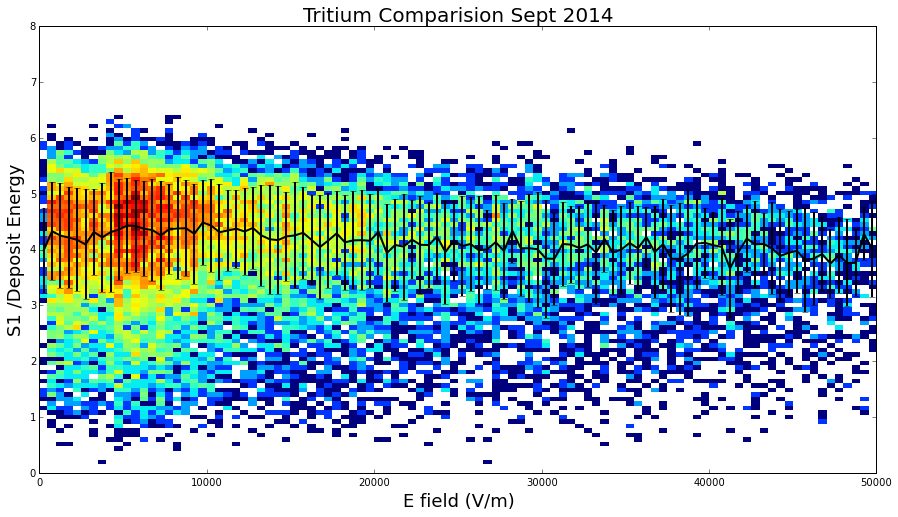

In [53]:
plt.figure(141)
plt.hist2d(Efield_ss4[~np.isnan(Efield_ss4)], S1_ss4[~np.isnan(Efield_ss4)]/Combined_energy_ss4[~np.isnan(Efield_ss4)],range=[[0,50000],[0,8]],bins=(100,100),norm=LogNorm())
bandfits141=bandfit(Efield_ss4[~np.isnan(Efield_ss4)], S1_ss4[~np.isnan(Efield_ss4)]/Combined_energy_ss4[~np.isnan(Efield_ss4)],range=[[0,50000],[0,8]],bins=(100,100))
plt.errorbar(bandfits141[2],bandfits141[0],bandfits141[1],lw=2, color="k",label="s1 sim")

plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1 /Deposit Energy", fontsize=18)
plt.title("Tritium Comparision Sept 2014", fontsize=20)

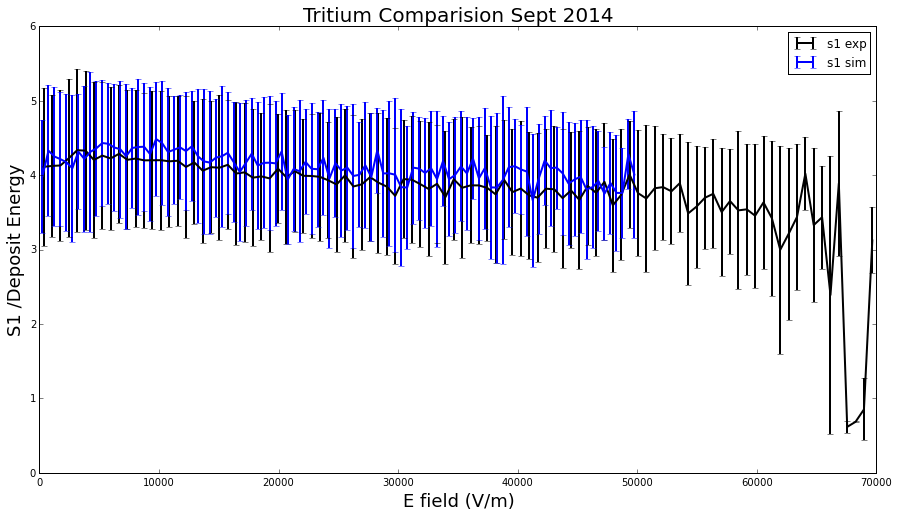

In [54]:
plt.figure(142)
plt.errorbar(bandfits140[2],bandfits140[0],bandfits140[1],lw=2, color="k",label="s1 exp")
plt.errorbar(bandfits141[2],bandfits141[0],bandfits141[1],lw=2, color="b",label="s1 sim")
plt.legend()
plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1 /Deposit Energy", fontsize=18)
plt.title("Tritium Comparision Sept 2014", fontsize=20)

Fitting data in bin  1 failed.
Fitting data in bin  90 failed.


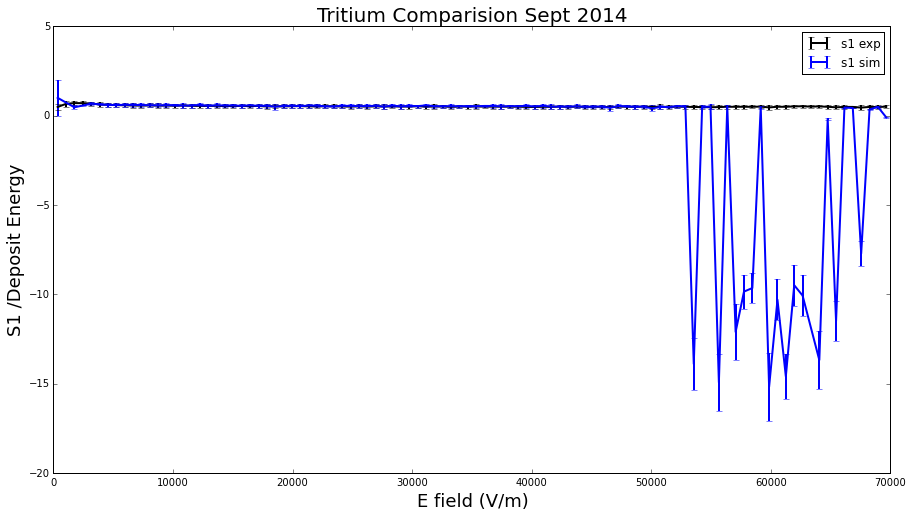

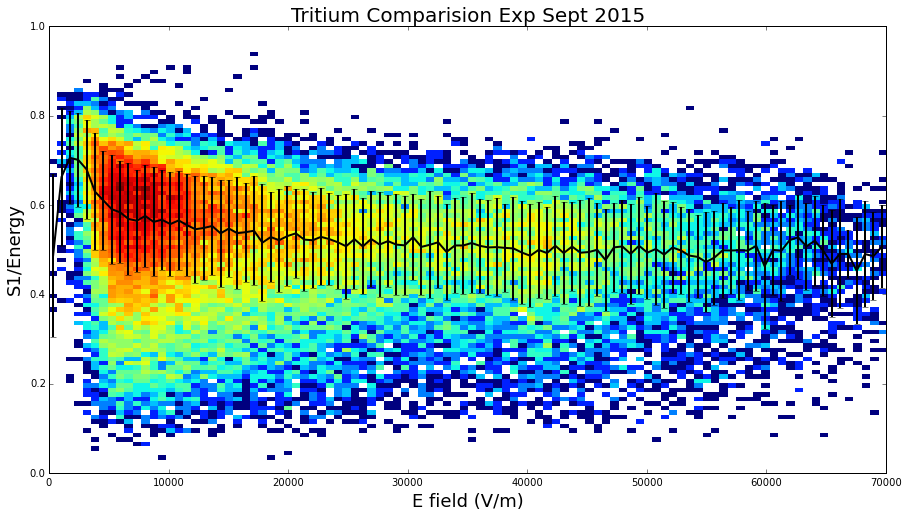

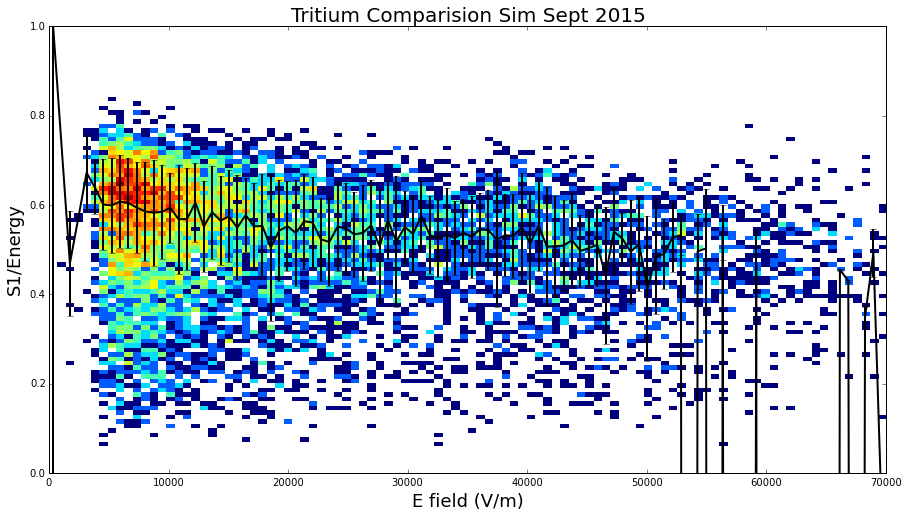

In [168]:
plt.figure(150)
plt.hist2d(Efield_s2_ts4[~np.isnan(Efield_s2_ts4)], S1_energy_t_ts4[~np.isnan(Efield_s2_ts4)]/Combined_energy_t_ts4[~np.isnan(Efield_s2_ts4)],range=[[0,70000],[0,1]],bins=(100,100),norm=LogNorm())
bandfits150=bandfit(Efield_s2_ts4[~np.isnan(Efield_s2_ts4)], S1_energy_t_ts4[~np.isnan(Efield_s2_ts4)]/Combined_energy_t_ts4[~np.isnan(Efield_s2_ts4)],range=[[0,70000],[0,1]],bins=(100,100))
plt.errorbar(bandfits150[2],bandfits150[0],bandfits150[1],lw=2, color="k",label="s1 sim")

plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1/Energy", fontsize=18)
plt.title("Tritium Comparision Exp Sept 2015", fontsize=20)

plt.figure(151)
plt.hist2d(Efield_s2_ss4[~np.isnan(Efield_s2_ss4)], S1_energy_ss4[~np.isnan(Efield_s2_ss4)]/Combined_energy_ss4[~np.isnan(Efield_s2_ss4)],range=[[0,70000],[0,1]],bins=(100,100),norm=LogNorm())
bandfits151=bandfit(Efield_s2_ss4[~np.isnan(Efield_s2_ss4)], S1_energy_ss4[~np.isnan(Efield_s2_ss4)]/Combined_energy_ss4[~np.isnan(Efield_s2_ss4)],range=[[0,70000],[0,1]],bins=(100,100))
plt.errorbar(bandfits151[2],bandfits151[0],bandfits151[1],lw=2, color="k",label="s1 sim")

plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1/Energy", fontsize=18)
plt.title("Tritium Comparision Sim Sept 2015", fontsize=20)

plt.figure(152)
plt.errorbar(bandfits150[2],bandfits150[0],bandfits150[1],lw=2, color="k",label="s1 exp")
plt.errorbar(bandfits151[2],bandfits151[0],bandfits151[1],lw=2, color="b",label="s1 sim")
plt.legend()
plt.xlabel("E field (V/m)", fontsize=18)
plt.ylabel("S1 /Deposit Energy", fontsize=18)
plt.title("Tritium Comparision Sept 2014", fontsize=20)

np.save(filedir+"201509explightyield",bandfits150)
np.save(filedir+"201509simlightyield",bandfits151)



In [110]:
plt.hist2d?

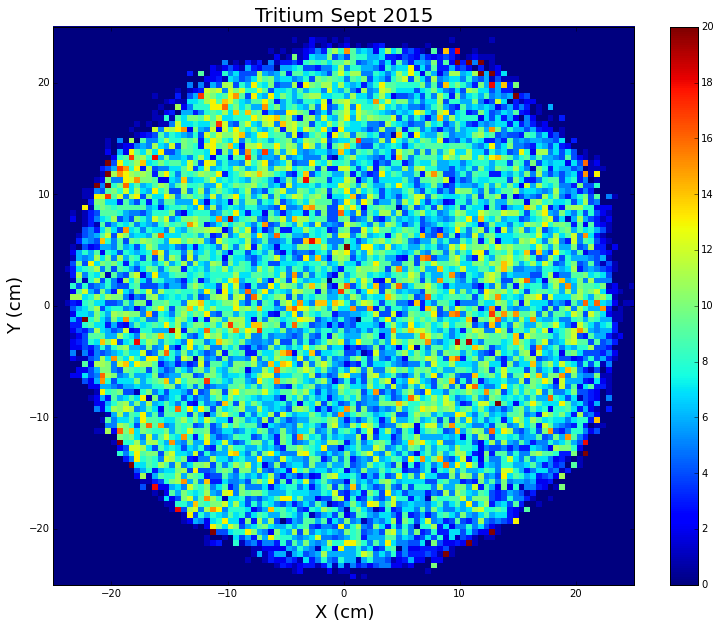

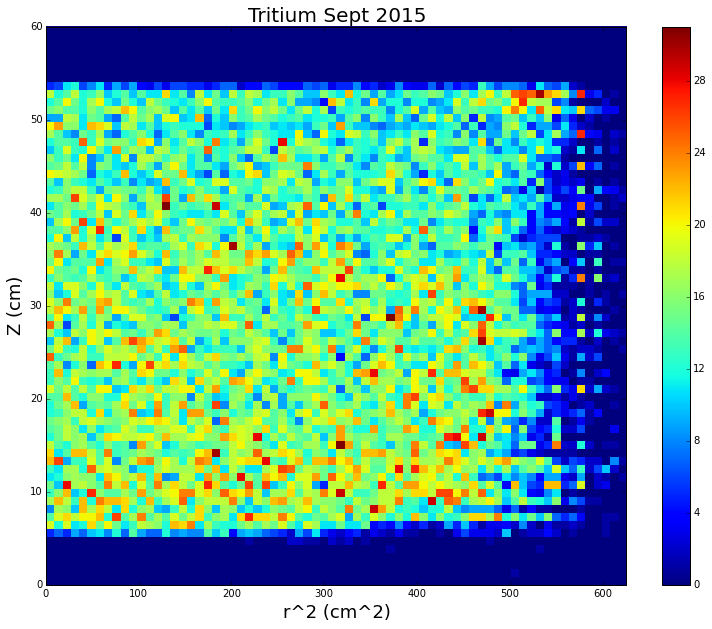

In [178]:
np.seterr(invalid='ignore')
# corrected reconstruction
plt.figure(160,figsize=(13,10))
plt.hist2d(x_real_s2_ts4,y_real_s2_ts4,range=[[-25,25],[-25,25]],bins=(100,100))
plt.clim(0,20)
cbar = plt.colorbar()
plt.xlabel("X (cm)", fontsize=18)
plt.ylabel("Y (cm)", fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

# z vs S2R^2
plt.figure(170,figsize=(13,10))
plt.hist2d(x_real_s2_ts4**2+y_real_s2_ts4**2,z_real_s2_ts4,range=[[0,25**2],[0,60]],bins=(70,70))
#plt.clim(0,1)
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("Z (cm)",fontsize=18)
plt.title("Tritium Sept 2015", fontsize=20)

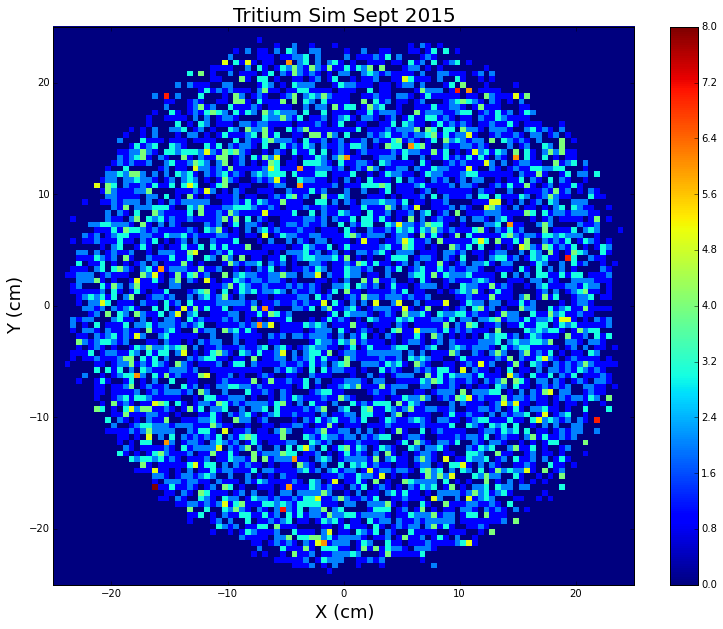

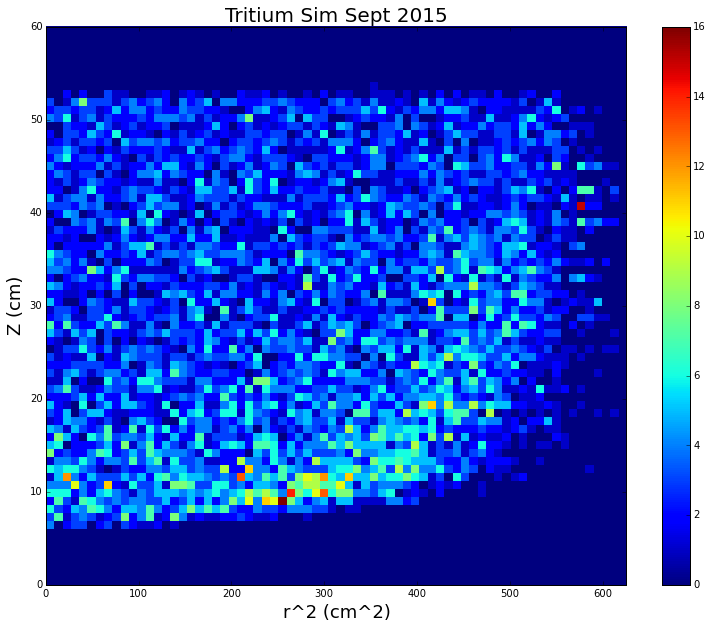

In [169]:
# corrected reconstruction
plt.figure(161,figsize=(13,10))
plt.hist2d(x_real_s2_ss4,y_real_s2_ss4,range=[[-25,25],[-25,25]],bins=(100,100))
#plt.clim(0,5)
cbar = plt.colorbar()
plt.xlabel("X (cm)", fontsize=18)
plt.ylabel("Y (cm)", fontsize=18)
plt.title("Tritium Sim Sept 2015", fontsize=20)
# z vs S2R^2
plt.figure(170,figsize=(13,10))
plt.hist2d(x_real_s2_ss4**2+y_real_s2_ss4**2,z_real_s2_ss4,range=[[0,25**2],[0,60]],bins=(70,70))
#plt.clim(0,10)
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("Z (cm)",fontsize=18)
plt.title("Tritium Sim Sept 2015", fontsize=20)

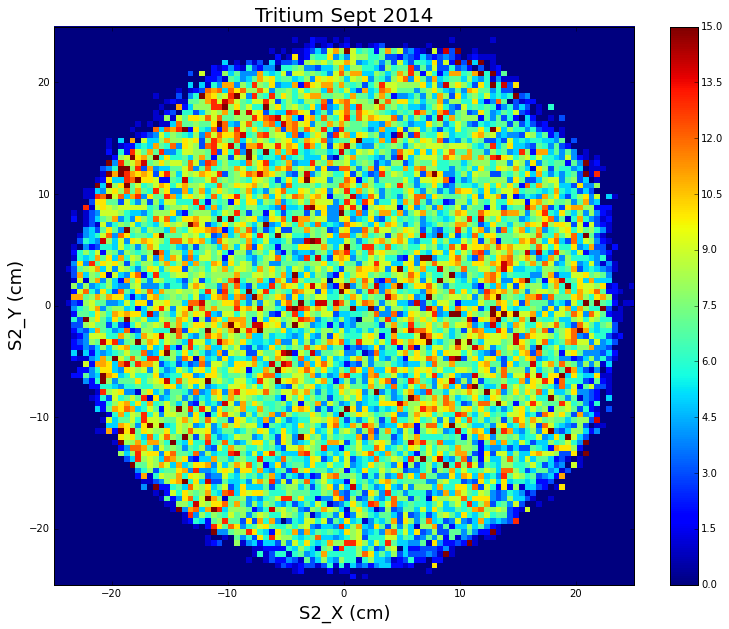

In [58]:
plt.figure(160,figsize=(13,10))
plt.hist2d(x_real_s2_ts4,y_real_s2_ts4,range=[[-25,25],[-25,25]],bins=(100,100))
plt.clim(0,15)
cbar = plt.colorbar()
plt.xlabel("S2_X (cm)", fontsize=18)
plt.ylabel("S2_Y (cm)", fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

In [65]:
a = np.where(x_real_s2_ts4**2+y_real_s2_ts4**2>500)[0]

In [68]:
b = np.where(z_real_s2_ts4<10)[0]

In [71]:
a_inds = np.in1d(a,b)
cornerindex = a[a_inds]

In [90]:
print x_real_s2_ts4[a]
print z_real_s2_ts4[b]

[ 15.88016854 -19.5         -0.32668113 ...,  12.45648196 -18.5
  -5.64718473]
[ 8.07744936  6.7392645   9.85595632 ...,  7.95267823  8.59406894
  6.84156424]


In [93]:
print x_real_s2_ts4[cornerindex]
print z_real_s2_ts4[cornerindex]
print raw_x_t_ts4[cornerindex]

[ 22.18249388 -22.5         -4.67063741  22.66158414  21.7621902
  21.17099082  -4.48066715 -10.72775077  -5.5        -17.18664424  -9.5
 -18.95528854 -17.374224   -22.5        -19.70658511 -19.94046228
 -22.30546972  20.99322445  13.22714481 -20.5        -20.46752779
  13.74893915  22.92504121   2.5        -19.5         22.5        -20.88054229
 -10.22948496 -22.5          1.87197923  21.5         22.62717926  20.5
 -14.5        -19.5         16.33640832 -14.5        -18.5        -15.5
  -6.08441925 -22.5         22.5        -22.5          1.10468389  22.5
   7.80032258  22.97332211  -7.5         -9.5         22.88611004  11.5
  24.54463096 -17.28706963  22.15243557  22.79092688  20.5        -20.5
 -16.5        -10.58546332 -19.5         -1.5          1.62262662 -19.5
 -21.5         -2.75866336  23.85930857 -13.77759275 -21.14696531 -20.5
 -20.5         11.39227347 -16.55533765  21.37192408  19.01881306
  21.30278973  19.5          0.5        -19.5         21.90921697 -20.5
  22.25106

In [97]:
if(1):
    Efield_corner_s2_ts4=[]
    x_real_corner_s2_ts4=[]
    y_real_corner_s2_ts4=[]
    z_real_corner_s2_ts4=[]
    for ii in cornerindex:
        temp = GetXYZFromXYZS2TDependentElectricField((raw_x_t_ts4[ii],raw_y_t_ts4[ii],drift_time_t_ts4[ii]),LoadEFieldMap,ifprint=1)
        x_real_corner_s2_ts4.append(temp[0])
        y_real_corner_s2_ts4.append(temp[1])
        z_real_corner_s2_ts4.append(temp[2])
        Efield_corner_s2_ts4.append(temp[3])
    Efield_corner_s2_ts4= np.array(Efield_corner_s2_ts4)
    x_real_corner_s2_ts4= np.array(x_real_corner_s2_ts4)
    y_real_corner_s2_ts4= np.array(y_real_corner_s2_ts4)
    z_real_corner_s2_ts4= np.array(z_real_corner_s2_ts4)

attempt 49
xx,yy,zz 26 24 24
attempt 48
xx,yy,zz 27 23 23
attempt 47
xx,yy,zz 28 22 22
attempt 46
xx,yy,zz 29 21 21
attempt 45
xx,yy,zz 30 20 20
attempt 44
xx,yy,zz 31 20 19
attempt 43
xx,yy,zz 32 20 18
attempt 42
xx,yy,zz 33 20 17
attempt 41
xx,yy,zz 34 20 16
attempt 40
xx,yy,zz 35 20 15
attempt 39
xx,yy,zz 36 20 14
attempt 38
xx,yy,zz 37 20 13
attempt 37
xx,yy,zz 37 20 12
attempt 36
xx,yy,zz 38 20 11
attempt 35
xx,yy,zz 38 20 10
attempt 34
xx,yy,zz 39 20 9
attempt 33
xx,yy,zz 40 20 8
attempt 32
xx,yy,zz 40 20 7
attempt 31
xx,yy,zz 41 20 6
attempt 30
xx,yy,zz 42 20 5
attempt 29
xx,yy,zz 43 19 4
attempt 28
xx,yy,zz 44 19 3
attempt 27
xx,yy,zz 45 19 4
attempt 26
xx,yy,zz 44 19 3
attempt 25
xx,yy,zz 45 19 4
attempt 24
xx,yy,zz 44 19 3
attempt 23
xx,yy,zz 45 19 4
attempt 22
xx,yy,zz 44 19 3
attempt 21
xx,yy,zz 45 19 4
attempt 20
xx,yy,zz 44 19 3
attempt 19
xx,yy,zz 45 19 4
attempt 18
xx,yy,zz 44 19 3
attempt 17
xx,yy,zz 45 19 4
attempt 16
xx,yy,zz 44 19 3
attempt 15
xx,yy,zz 45 19 4
attem

In [95]:
    Efield_corner_s2_ts4= np.array(Efield_corner_s2_ts4)
    x_real_corner_s2_ts4= np.array(x_real_corner_s2_ts4)
    y_real_corner_s2_ts4= np.array(y_real_corner_s2_ts4)
    z_real_corner_s2_ts4= np.array(z_real_corner_s2_ts4)

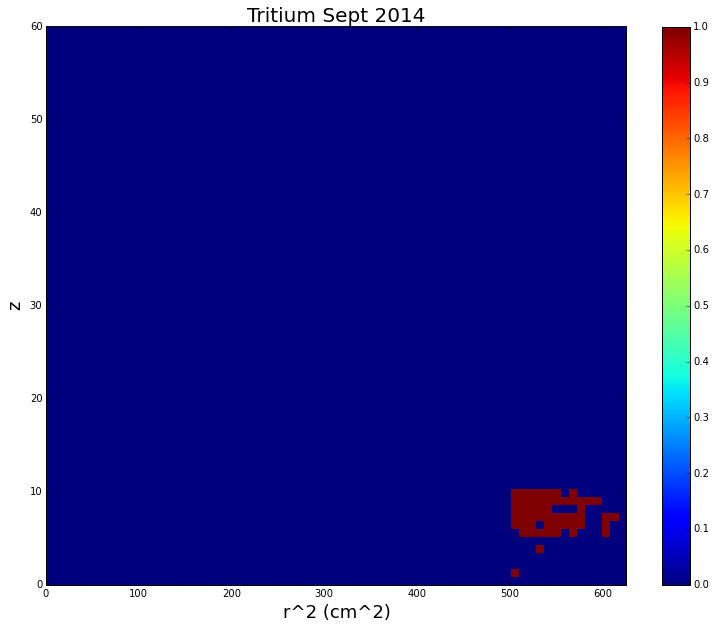

In [98]:

# z vs S2R^2
plt.figure(170,figsize=(13,10))
plt.hist2d(x_real_corner_s2_ts4**2+y_real_corner_s2_ts4**2,z_real_corner_s2_ts4,range=[[0,25**2],[0,60]],bins=(70,70))
plt.clim(0,1)
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("z",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

In [105]:
Efieldmap = np.loadtxt("/global/homes/w/weiji/20150208/v0_fields_20140903T1918_cp17059.txt")
LoadEFieldMap = LoadXYZDependentEField(Efieldmap)

In [106]:
if(1):
    Efield_s2_ss4=[]
    x_real_s2_ss4=[]
    y_real_s2_ss4=[]
    z_real_s2_ss4=[]
    for ii in xrange(10000):
        temp = GetXYZFromXYZS2TDependentElectricField((raw_x_ss4[ii],raw_y_ss4[ii],drift_time_ss4[ii]),LoadEFieldMap)
        x_real_s2_ss4.append(temp[0])
        y_real_s2_ss4.append(temp[1])
        z_real_s2_ss4.append(temp[2])
        Efield_s2_ss4.append(temp[3])
    Efield_s2_ss4= np.array(Efield_s2_ss4)
    x_real_s2_ss4= np.array(x_real_s2_ss4)
    y_real_s2_ss4= np.array(y_real_s2_ss4)
    z_real_s2_ss4= np.array(z_real_s2_ss4)

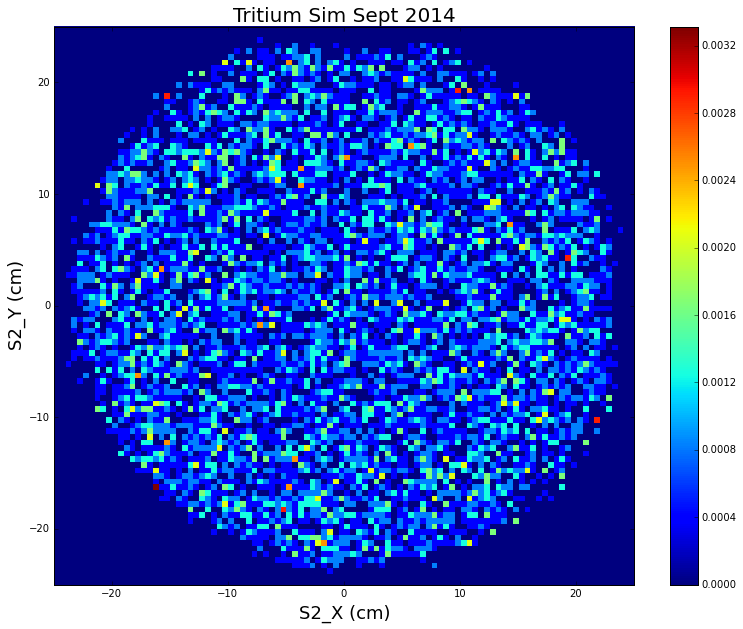

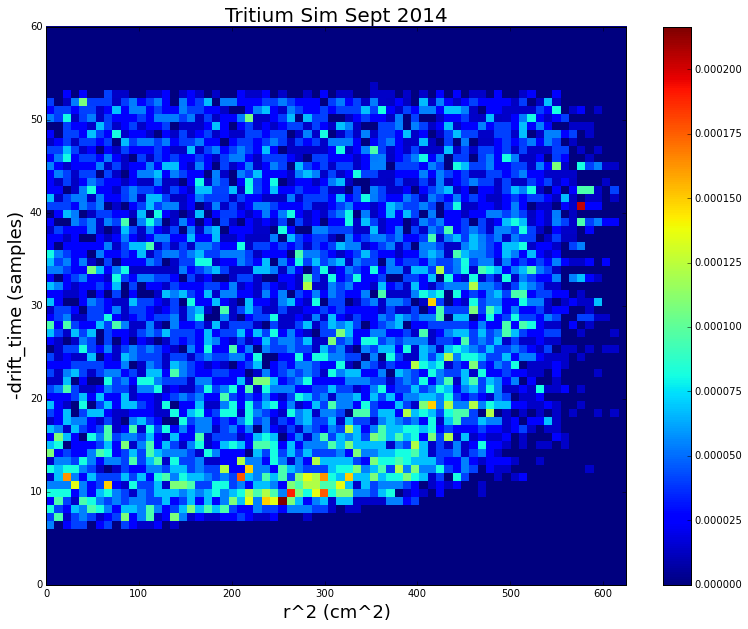

In [164]:
# corrected reconstruction
plt.figure(161,figsize=(13,10))
plt.hist2d(x_real_s2_ss4,y_real_s2_ss4,range=[[-25,25],[-25,25]],bins=(100,100),normed=True)
#plt.clim(0,5)
cbar = plt.colorbar()
plt.xlabel("S2_X (cm)", fontsize=18)
plt.ylabel("S2_Y (cm)", fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)
# z vs S2R^2
plt.figure(170,figsize=(13,10))
plt.hist2d(x_real_s2_ss4**2+y_real_s2_ss4**2,z_real_s2_ss4,range=[[0,25**2],[0,60]],bins=(70,70),normed=True)
#plt.clim(0,10)
cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("-drift_time (samples)",fontsize=18)
plt.title("Tritium Sim Sept 2014", fontsize=20)

In [121]:
23.5**2

552.25

In [147]:
def boolstr_to_floatstr(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v

In [150]:
linx=np.linspace(-23.5,24.5,48)

In [151]:
linz=np.linspace(5.6,5.6+49,50)

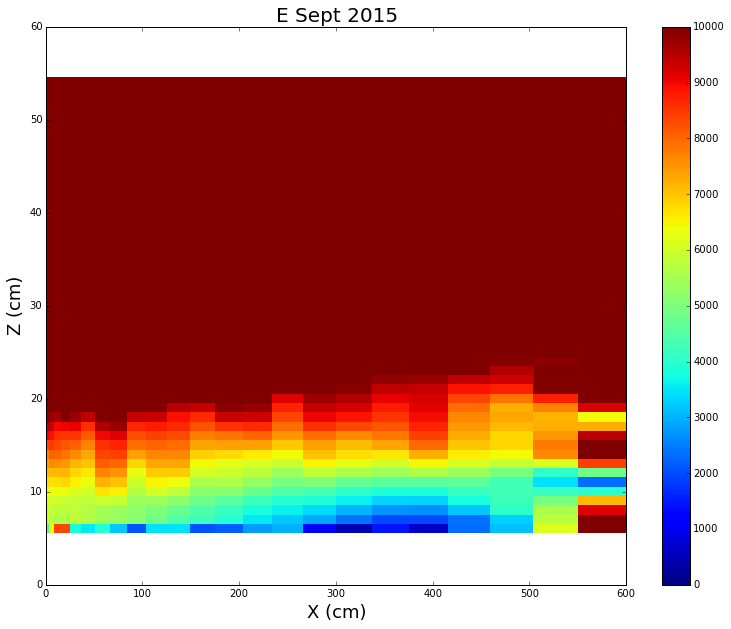

In [174]:
plt.figure(1,figsize=(13,10))
plt.pcolor(linx**2,linz,LoadEFieldMap[0][:,25,:,3].T)
cbar = plt.colorbar()
plt.clim(0,10000)
plt.xlim(0,600)
plt.ylim(0,60)
plt.xlabel("X (cm)", fontsize=18)
plt.ylabel("Z (cm)", fontsize=18)
plt.title("E Sept 2015", fontsize=20)

In [157]:
LoadEFieldMap[0][:,25,:,7]

array([[ 2.,  1.,  1., ...,  1.,  1.,  0.],
       [ 2.,  1.,  1., ...,  1.,  1.,  0.],
       [ 2.,  1.,  1., ...,  1.,  1.,  0.],
       ..., 
       [ 2.,  1.,  1., ...,  1.,  1.,  0.],
       [ 2.,  1.,  1., ...,  1.,  1.,  0.],
       [ 2.,  1.,  1., ...,  1.,  1.,  0.]])